This notebook describes the temporal fusion transformers [@lim2021temporal] architecture, and ports it over to keras 3 while making some punctual improvements, including bringing the notation closer to the one in the paper.

The original repository is [here](https://github.com/google-research/google-research/tree/master/tft).

In [1]:
# | output: false

from __future__ import annotations

import os
import torch

os.environ["KERAS_BACKEND"] = "torch"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from datetime import timedelta
from dateutil.relativedelta import relativedelta
from fastcore import docments
from nbdev.showdoc import show_doc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Introduction

The main characteristics of TFT that make it interesting for nowcasting or forecasting purposes are:

- **multi-horizon forecasting**: the ability to output, at each point in time $t$, a sequence of forecasts for $t+h, h > 1$
- **quantile prediction**: each forecast is accompanied by a quantile band that communicates the amount of uncertainty around a prediction
- **flexible use of different types of inputs**: static inputs (akin to fixed effects), historical input and known future input (eg, important holidays, years that are known to have major sports events such as Olympic games, etc)
- **interpretability**: the model learns to select variables from the space of all input variables to retain only those that are globally meaningful, to assign attention to different parts of the time series, and to identify events of significance

## Main innovations

The present model includes the following innovations:

- **Multi-frequency input**

- **Context enhancement from lagged target**: the last known values of the target variable are embedded (bag of observations), and this embedding is used similar to the static context enhancement as a starting point for the cell value in the *decoder* LSTM.

# Preparing the data

The functions below will be tested with simulated and real data. The former helps to illustrate issues like dimensions and overall behaviour of a layer, whereas the latter will demonstrate on a real setting in economics how the input and output data relate to one another.

More specifically, the real data used will be a daily nowcasting exercise of monthly inflation. Note that the models will not necessarily perform well, since their use here is for illustration purposes and thus they are not optimised. Also, the dataset is not an ideal one for nowcasting: other variables could also be considered.

## Download economic data

This is a panel dataset. In addition to the time dimension, it can contain any number of categorical dimensions - for example, combine country and sector.

## Prepare data

In [2]:
data_path = r"L:\MED\TRAN\2021_Nowcasting\data\dataset_new\nowcast_dataset_complete_May-28-2024.csv"

countries = ["CA", "CH", "DE", "FR", "GB", "IN", "JP", "US"]


columns = [
    "equity",
    "fx",
    "Cab",
    "ShortGovYield",
    "LongGovYield",
    "UnempRate",
    "neer",
    "policyRate",
    "energy",
    "food",
    "metal",
]


start_date = "1980-01-01"

variables = {
    "d": [
        "banksPriceIdx",
        "policyRate",
        "LongGovYield",  # no values for AU and IN
        "ShortGovYield",  # no values for AU and IN
        "equity",
        "equityPE",
        "equityVol",
        "fx",
        "neer",
        "brent",
        "lmex",
        "crbFood",
        "OAScorpSpreadIG",
        "OAScorpSpreadHY",
        "gsFci",
        "gvtBondYld10y",
        "gvtBondYld3m",
        "gvtBondYld1y",
        "gvtBondYld2y",  # only values for AU and IN
    ],
    "m": [
        "energy",
        "nonFuel",
        "food",
        "metal",
        "retailSales",
        "CPIh",
        "CPIhLong",
        "ip",
        "UnempRate",
        "m3sa",
        "m1",
        "OecdLeadingInd",
        "FXres",
        "pmiMan",
        "pmiSer",
        # "pmiWhe",
        "pmiCom",
        "EPFRbond",
        "EPFRequity",
        "banking_crisis",
    ],
    "q": [
        "GDP",
        "Consumption",
        "Gfcf",
        # "EmpRate",
        "creditTOT2GDP",
        "creditHH2GDP",
        "creditNFC2GDP",
        "creditGVT2GDP",
        "creditTOT",
        "creditHH",
        "creditNFC",
        "creditGVT",
        "credit2GDPgap",
        "credit2GDPtrend",
        "dsrHHlong",
        "dsrTOTlong",
        "dsrNFClong",
        "LBSbankLiab",
        "PortInvFlow",
        "PortInvLiab",
        "PortInvAsset",
        "PortInvLiabNet",
        "resPrice",
        "resPriceReal",
        "Cab",
    ],
}

In [3]:
from nowcastml.data.load import load_multi_freq_data, build_target_frames

In [4]:
dfs_input = load_multi_freq_data(
    data_path, countries=countries, variables=variables, start_date=start_date
)
for freq, df in dfs_input.items():
    print(f"Frequency: {freq}")
    display(df)

Frequency: d


,banksPriceIdx__CA,banksPriceIdx__CH,banksPriceIdx__DE,banksPriceIdx__FR,banksPriceIdx__GB,banksPriceIdx__IN,banksPriceIdx__JP,banksPriceIdx__US,policyRate__CA,policyRate__CH,...,gvtBondYld1y__JP,gvtBondYld1y__US,gvtBondYld2y__CA,gvtBondYld2y__CH,gvtBondYld2y__DE,gvtBondYld2y__FR,gvtBondYld2y__GB,gvtBondYld2y__IN,gvtBondYld2y__JP,gvtBondYld2y__US
index,,,,,,,,,,,,,,,,,,,,,
1980-01-01,137.95,198.41,95.88,NaN,356.13,NaN,81.24,75.19,14.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,137.33,198.41,94.25,NaN,350.96,NaN,81.24,75.01,14.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,134.61,198.63,93.21,NaN,350.20,NaN,81.24,74.51,14.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,134.82,197.23,94.55,NaN,352.89,NaN,81.44,74.95,14.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,134.82,197.23,94.55,NaN,352.89,NaN,81.44,74.95,14.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,5001.01,469.62,100.88,569.81,3476.96,52370.55,287.28,1716.42,5.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.984,NaN,NaN
2024-05-25,5001.01,469.62,100.88,569.81,3476.96,52370.55,287.28,1716.42,5.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.984,NaN,NaN
2024-05-26,5001.01,469.62,100.88,569.81,3476.96,52370.55,287.28,1716.42,5.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.984,NaN,NaN


Frequency: m


,energy__CA,energy__CH,energy__DE,energy__FR,energy__GB,energy__IN,energy__JP,energy__US,nonFuel__CA,nonFuel__CH,...,EPFRequity__JP,EPFRequity__US,banking_crisis__CA,banking_crisis__CH,banking_crisis__DE,banking_crisis__FR,banking_crisis__GB,banking_crisis__IN,banking_crisis__JP,banking_crisis__US
index,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,175.18,175.18,175.18,175.18,175.18,175.18,175.18,175.18,148.72,148.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01,173.66,173.66,173.66,173.66,173.66,173.66,173.66,173.66,149.39,149.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01,173.23,173.23,173.23,173.23,173.23,173.23,173.23,173.23,148.66,148.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Frequency: q


,GDP__CA,GDP__CH,GDP__DE,GDP__FR,GDP__GB,GDP__IN,GDP__JP,GDP__US,Consumption__CA,Consumption__CH,...,resPriceReal__JP,resPriceReal__US,Cab__CA,Cab__CH,Cab__DE,Cab__FR,Cab__GB,Cab__IN,Cab__JP,Cab__US
index,,,,,,,,,,,,,,,,,,,,,
1980-01-01,223.0458,90.3561,422.219852,291.285,243.513,NaN,67436.875,1835.3893,NaN,50.174554,...,117.641360,81.064928,NaN,NaN,NaN,NaN,-0.569984,NaN,NaN,-0.495942
1980-04-01,222.9483,90.4965,419.518729,289.022,238.722,NaN,67130.450,1797.5723,NaN,50.203003,...,117.735149,79.213469,NaN,NaN,NaN,NaN,-0.791159,NaN,NaN,-0.134556
1980-07-01,222.7630,90.9576,417.871755,289.339,238.432,NaN,68545.775,1795.4358,NaN,50.332773,...,120.215918,80.256954,NaN,NaN,NaN,NaN,1.161752,NaN,NaN,0.606760
1980-10-01,225.8453,91.4835,417.344799,288.843,235.866,NaN,69900.450,1828.9193,NaN,50.576117,...,121.884905,79.824920,NaN,NaN,NaN,NaN,2.194077,NaN,NaN,0.319270
1981-01-01,230.7108,91.4475,422.219852,289.825,235.712,NaN,70498.925,1864.7555,116.81325,50.526634,...,123.894472,79.235266,-4.140542,NaN,NaN,NaN,3.799025,NaN,NaN,0.123295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,587.1440,191.5362,818.222000,589.375,569.027,NaN,139357.025,5528.0823,341.84875,96.388193,...,122.959996,157.597126,-0.954517,8.382241,5.317964,-1.123465,-2.379062,-0.792408,1.665666,-3.199451
2023-04-01,588.0740,191.1890,817.617000,593.156,569.076,NaN,140780.650,5556.3375,341.97575,96.734600,...,121.582294,157.489082,-1.023738,7.919468,6.906945,-0.080223,-3.546464,-1.176351,3.943665,-3.204447
2023-07-01,587.3320,191.6721,818.752000,593.602,568.397,NaN,139505.075,5622.6730,342.15750,96.893932,...,120.902817,159.320804,-0.443942,10.865852,8.445304,-1.769199,-2.506553,-0.702076,4.138314,-2.901892


In [5]:
df_target_1m_pct, df_target_12m_pct = build_target_frames(dfs_input["m"], "CPIh")
display(df_target_1m_pct)
display(df_target_12m_pct)

,CA,CH,DE,FR,GB,IN,JP,US
index,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-01,1.196172,0.140962,1.239669,1.061571,1.033592,1.580000,0.853485,1.413882
1980-03-01,0.709220,0.309237,0.408163,1.155462,1.278772,0.826934,0.564175,1.520913
1980-04-01,0.704225,0.457822,0.542005,1.246106,3.282828,0.761570,1.823282,1.123596
1980-05-01,1.165501,0.595242,0.539084,0.820513,0.733496,2.131783,0.826446,0.987654
...,...,...,...,...,...,...,...,...
2023-12-01,-0.314861,0.048609,0.085251,0.135329,0.379651,-0.322061,-0.093545,-0.099332
2024-01-01,0.000000,0.170518,0.170358,-0.168933,-0.529501,-0.107701,0.093633,0.544750
2024-02-01,0.315856,0.636546,0.425170,0.863017,0.608365,0.161725,0.000000,0.618967


,CA,CH,DE,FR,GB,IN,JP,US
index,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-01,3.396473,1.714889,3.710247,3.705326,3.930818,5.691520,2.593660,3.352123
2024-01-01,2.858999,1.278613,2.887139,3.132635,4.034810,5.099150,2.101242,3.090885
2024-02-01,2.783172,1.168413,2.517361,2.962515,3.440188,5.090498,2.788462,3.153171


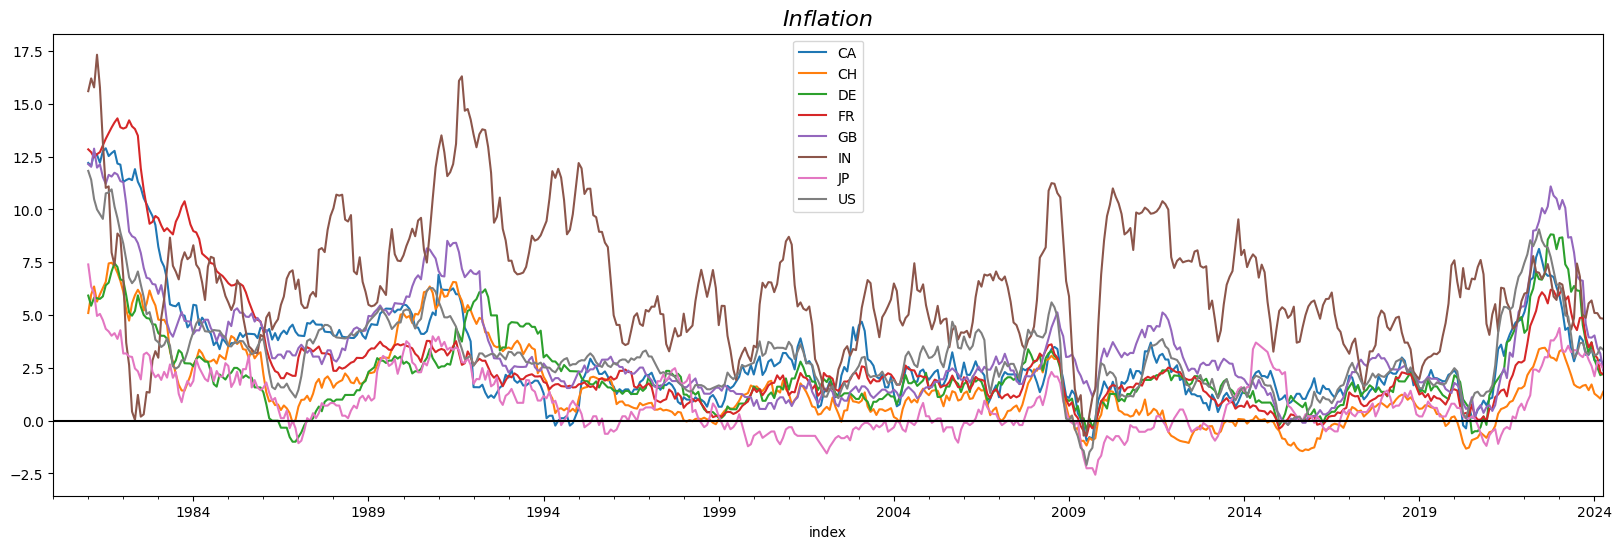

In [6]:
# | fig-align: center

ax = df_target_12m_pct.plot(figsize=(20, 6))
ax.axhline(y=0, color="black")
ax.set_title("Inflation", fontsize=16, fontstyle="italic")
plt.show()

## Date features

In addition to data provided by the user, the model automatically loads categorical features related to each date.

In [7]:
def date_features(
    date_range,  # Range of dates for which to create date features
    is_monthly: bool = False,  # Is the date measured at the monthly frequency?
) -> pd.DataFrame:  # Categorical date features
    "Categorical features for each day in a range of dates"
    if is_monthly:
        return pd.DataFrame({"Month of Year": date_range.month})
    else:
        return pd.DataFrame(
            {
                "Day of Week": date_range.dayofweek
                + 1,  # This is the only date feature with zeros, which are masked out
                "Day of Month": date_range.day,
                "Day of Year": date_range.dayofyear,
                "Week of Month": (date_range.day - 1) // 7 + 1,
                "Week of Year": pd.Index(date_range.isocalendar().week).astype("int32"),
                "Month of Year": date_range.month,
            }
        )

In [8]:
# | output: asis
# | echo: false

show_doc(date_features, title_level=3)

---

### date_features

>      date_features (date_range, is_monthly:bool=False)

*Categorical features for each day in a range of dates*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| date_range |  |  | Range of dates for which to create date features |
| is_monthly | bool | False | Is the date measured at the monthly frequency? |
| **Returns** | **pd.DataFrame** |  | **Categorical date features** |

In [9]:
# | code-fold: show

date_features(dfs_input["d"].index)[:10]

,Day of Week,Day of Month,Day of Year,Week of Month,Week of Year,Month of Year
0,2,1,1,1,1,1
1,3,2,2,1,1,1
2,4,3,3,1,1,1
3,5,4,4,1,1,1
4,6,5,5,1,1,1
5,7,6,6,1,1,1
6,1,7,7,1,2,1
7,2,8,8,2,2,1
8,3,9,9,2,2,1
9,4,10,10,2,2,1


### Combining the date features in the main data

In [10]:
date_feat = {}

for freq, df_input in dfs_input.items():
    date_feat_freq = date_features(df_input.index)
    date_feat_freq.index = df_input.index

    df_input = pd.concat([df_input, date_feat_freq], axis=1)
    dfs_input[freq] = df_input
    date_feat[freq] = date_feat_freq

## Splitting the dataset

This step needs to be done somewhat differently than normal datasets: In the validation and test periods, the input data can very well be from the previous chunk (training and validation, respectively).

In practice, this means that we just need to split the **dates** at which the nowcasting will take place. Then, a data loading function (see @sec-dataloaders) can read from the whole time series to look back from that date as needed according to the desired time window.

In [11]:
start_date = dfs_input["d"].index.min()
end_date = dfs_input["d"].index.max()
cutoff_date_train = pd.to_datetime("2005-01-01")
cutoff_date_valid = pd.to_datetime("2020-01-01")

dates_train = pd.date_range(start_date, cutoff_date_train - timedelta(days=1))
dates_valid = pd.date_range(cutoff_date_train, cutoff_date_valid - timedelta(days=1))
dates_test = pd.date_range(cutoff_date_valid, end_date)

Now all input variables that are not available in the training dataset are removed, and only those with at least some information are kept.

In [12]:
for freq, df_input in dfs_input.items():
    keep_cols = (
        df_input.loc[min(dates_train) : max(dates_train)]
        .dropna(axis=1, how="all")
        .columns
    )

    dfs_input[freq] = df_input[keep_cols]

## Identifying continuous and categorical variables {#sec-contcat}

 The model distinguishes continuous from categorical variables if the user does not provide a list of variable names in a simple (simplistic) way: integer-valued variables that start with one are considered categorical, all other are continuous.

The criteria that categorical variables start with one is to ensure that the user does not unwarrantedly pass on categorical variables with zero, since zeros are considered to be a padding for variable-length input data.

For variables that are naturally valued in integers, such as the count of number of firms, etc, the user can either ensure there is a zero amongst the integer at any time of the **training** input data, or convert these values to floating numbers. Another alternative that might be relevant in some cases is to use the natural logarithm of that data.

In [13]:
cont_cols = {}
cat_cols = {}

for freq, df_input in dfs_input.items():
    int_cols = df_input.select_dtypes(include=["int"]).columns

    float_cols = df_input.select_dtypes(include=["float"]).columns

    # Columns that are float but actually contain integer values starting with one
    cat_cols_tmp = []

    for col in int_cols:

        if min(df_input[col]) > 0:

            cat_cols_tmp.append(col)

    for col in float_cols:

        if (df_input[col] % 1 == 0).all() and min(
            df_input[col]
        ) > 0:  # Check if the fractional part is 0 for all values and the lowest integer is 1

            cat_cols_tmp.append(col)

    cont_cols_tmp = [c for c in df_input.columns if c not in cat_cols_tmp]

    assert len(cont_cols_tmp) + len(cat_cols_tmp) == df_input.shape[1]
    cont_cols[freq] = cont_cols_tmp
    cat_cols[freq] = cat_cols_tmp

Further, the categorical variables require a dictionary that indicates the cardinality of each variable.

## Scaling the continuous variables

The input series need to be scaled, according to the training data mean and standard deviation.

The target series will not be scaled because it is already a small number close to zero that is not exploding in nature.

In [14]:
# | warning: false
dfs_input_scl = {}

for freq, df_input in dfs_input.items():
    scl = StandardScaler()
    scl.fit(df_input.loc[dates_train.min() : dates_train.max(), cont_cols[freq]])
    df_input_scl = pd.DataFrame(
        scl.transform(df_input[cont_cols[freq]]),
        index=df_input.index,
        columns=cont_cols[freq],
    )
    df_input_scl = pd.concat([df_input_scl, date_feat[freq]], axis=1)

    assert df_input_scl.shape == df_input.shape

    dfs_input_scl[freq] = df_input_scl

## Cardinality of categorical variables

Each categorical variable has its own cardinality. This value is important when creating the embedding layer for each variable; see @sec-input.

In [15]:
cardin_hist = {c: len(dfs_input_scl["d"][c].unique()) + 1 for c in cat_cols_tmp}

cardin_hist

{'Day of Week': 8,
 'Day of Month': 32,
 'Day of Year': 367,
 'Week of Month': 6,
 'Week of Year': 54,
 'Month of Year': 13}

The cardinality of the static variable(s) must also be included:

In [16]:
cardin_stat = dict(Countries=len(df_target_1m_pct.columns) + 1)

The country list also requires an encoding/decoding dictionary for subsequent analyses.

In [17]:
country_enc_dict = {cty: idx + 1 for idx, cty in enumerate(df_target_1m_pct.columns)}
country_dec_dict = {idx: cty for cty, idx in country_enc_dict.items()}

## Dealing with missing data


Missing data is dealt with by replacing `NaN`s in the input data with zeros. This has two effects:

* it prevents embedding categorical variables since zeros are masked out

* for the continuous data, the input layer weights do not pick up any information, and the constant (or "bias" in machine learning language) is responsible for conveying any information to subsequent neurons.

A more sophisticated approach would be to estimate missing data based on other contemporaneous and past data. For simplicity, this approach will not be followed in this example.

Obviously this step needs to be done after the input data is scaled, otherwise the zeros would be wrongly contributing to the mean and standard deviation values.

In [18]:
for freq, df_input_scl in dfs_input_scl.items():
    dfs_input_scl[freq] = df_input_scl.fillna(0)

Finally, we remove the input months for which there is no inflation data (eg, due to the one-month growth calculation):

In [19]:
for freq, df_input_scl in dfs_input_scl.items():
    dfs_input_scl[freq] = df_input_scl[df_target_1m_pct.dropna().index.min() :]

## Splitting the data

Now we separate the training, validation and test data.
Once again, this is done per frequency:

In [20]:
df_input_train = {}
df_input_valid = {}
df_input_test = {}

for freq, df_input_scl in dfs_input_scl.items():
    df_input_train[freq] = df_input_scl[: dates_train.max()]

    df_input_valid[freq] = df_input_scl[dates_train.max() : dates_valid.max()]

    df_input_test[freq] = df_input_scl[dates_valid.max() : dates_test.max()]

    print(
        freq,
        df_input_train[freq].shape[0],
        df_input_valid[freq].shape[0],
        df_input_test[freq].shape[0],
    )

d 9101 5479 1611
m 299 180 52
q 99 60 17


In [21]:
df_input_train["m"]

,energy__CA,energy__CH,energy__DE,energy__FR,energy__GB,energy__IN,energy__JP,energy__US,nonFuel__CA,nonFuel__CH,...,banking_crisis__FR,banking_crisis__GB,banking_crisis__JP,banking_crisis__US,Day of Week,Day of Month,Day of Year,Week of Month,Week of Year,Month of Year
index,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,5,1,32,1,5,2
1980-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,6,1,61,1,9,3
1980-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,2,1,92,1,14,4
1980-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,4,1,122,1,18,5
1980-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,7,1,153,1,22,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-08-01,2.681972,2.681972,2.681972,2.681972,2.681972,2.681972,2.681972,2.681972,1.406574,1.406574,...,0.0,0.0,0.0,0.0,7,1,214,1,31,8
2004-09-01,2.615042,2.615042,2.615042,2.615042,2.615042,2.615042,2.615042,2.615042,1.503147,1.503147,...,0.0,0.0,0.0,0.0,3,1,245,1,36,9
2004-10-01,3.363086,3.363086,3.363086,3.363086,3.363086,3.363086,3.363086,3.363086,1.612012,1.612012,...,0.0,0.0,0.0,0.0,5,1,275,1,40,10


## Data loaders {#sec-dataloaders}

Ideally a data loader should:

* create a pair of input/target data

* the input data should contain:

    * continuous data from all countries

    * categorical date features

    * categorical feature of the country (ie, which country it is)

    * known future inputs

On the known future inputs: those will be essentially the categorical date features, broadcasted until the end of the desired month to be nowcasted (ie, either the current month or a future one). The nowcast will then be the value of inflation at the end of the "as-of" month.

> Note: so far, the only known future data used by the model are the categorical features from the dates up to the last day of the nowcasted/forecasted month. However, an important known future data for inflation are the central bank policy variables. These are not yet dealth with in this code, but a future version should incorporate an intelligent way for users to input a vector of policy variables, with the dates up until which they would be known. This could be done in a separate DataFrame with policy variables, which would arguably facilitate working with this data separately from all others.

In [22]:
def pad_to_context_length(
    df_daily: pd.DataFrame, df_monthly: pd.DataFrame, df_quarterly, context_length: int
):
    # Pad the daily frequency DataFrame
    if df_daily.shape[0] < context_length:
        df_pad_daily = pd.DataFrame(
            np.zeros((context_length - df_daily.shape[0], df_daily.shape[1])),
            columns=df_daily.columns,
        )
        df_pad_daily.index = pd.date_range(
            end=df_daily.index.min() - pd.Timedelta(days=1),
            periods=(context_length - df_daily.shape[0]),
            freq="D",
        )
        df_daily = pd.concat([df_pad_daily, df_daily])
    # Resample the daily DataFrame to a monthly frequency to get the new indices
    monthly_index = df_daily.resample("MS").asfreq().index
    quarterly_index = df_daily.resample("QS").asfreq().index

    # Pad the monthly frequency DataFrame to match the dates in the monthly_index
    if df_monthly.shape[0] < len(monthly_index):
        df_pad_monthly = pd.DataFrame(
            np.zeros((len(monthly_index) - df_monthly.shape[0], df_monthly.shape[1])),
            columns=df_monthly.columns,
        )
        df_pad_monthly.index = monthly_index[: len(df_pad_monthly)]
        df_monthly = pd.concat([df_pad_monthly, df_monthly])
        df_monthly.index = monthly_index

    # Pad the quarterly frequency DataFrame to match the dates in the quarterly_index
    if df_quarterly.shape[0] < len(quarterly_index):
        df_pad_quarterly = pd.DataFrame(
            np.zeros(
                (len(quarterly_index) - df_quarterly.shape[0], df_quarterly.shape[1])
            ),
            columns=df_quarterly.columns,
        )
        df_pad_quarterly.index = quarterly_index[: len(df_pad_quarterly)]
        df_quarterly = pd.concat([df_pad_quarterly, df_quarterly])
        df_quarterly.index = quarterly_index

    return df_daily, df_monthly, df_quarterly

In [23]:
# Example usage
date_rng_daily = pd.date_range(start="2020-01-07", end="2020-06-10", freq="D")
df_daily = pd.DataFrame(
    range(len(date_rng_daily)), index=date_rng_daily, columns=["data"]
)

date_rng_monthly = pd.date_range(start="2020-01-07", end="2020-06-10", freq="MS")
df_monthly = pd.DataFrame(
    range(len(date_rng_monthly)), index=date_rng_monthly, columns=["data"]
)

date_rng_quarterly = pd.date_range(start="2020-01-07", end="2020-06-10", freq="QS")
df_quarterly = pd.DataFrame(
    range(len(date_rng_quarterly)), index=date_rng_quarterly, columns=["data"]
)


context_length = 180
pad_to_context_length(df_daily, df_monthly, df_quarterly, context_length)

(             data
 2019-12-14    0.0
 2019-12-15    0.0
 2019-12-16    0.0
 2019-12-17    0.0
 2019-12-18    0.0
 ...           ...
 2020-06-06  151.0
 2020-06-07  152.0
 2020-06-08  153.0
 2020-06-09  154.0
 2020-06-10  155.0
 
 [180 rows x 1 columns],
             data
 2019-12-01   0.0
 2020-01-01   0.0
 2020-02-01   0.0
 2020-03-01   1.0
 2020-04-01   2.0
 2020-05-01   3.0
 2020-06-01   4.0,
             data
 2019-10-01   0.0
 2020-01-01   0.0
 2020-04-01   0.0)

In [24]:
from nowcastml.data.dataloader import sample_dates

earliest_date, sampled_day = sample_dates(df_input_train["d"], 90, 12, 365)

for freq, df in df_input_train.items():
    df_hist = df.loc[earliest_date:sampled_day]
    print(df_hist.shape)

(242, 113)
(8, 119)
(3, 173)


In [25]:
from nowcastml.data.dataloader import sample_nowcasting_data

show_doc(sample_nowcasting_data, title_level=3)

---

### sample_nowcasting_data

>      sample_nowcasting_data (dfs_input:dict[str,pandas.core.frame.DataFrame],
>                              df_target:pandas.core.frame.DataFrame,
>                              country_enc_dict:dict[str,int],
>                              country_dec_dict:dict[int,str], cont_cols,
>                              cat_cols, min_context:int=90,
>                              context_length:int=365, num_months:int=12,
>                              sampled_day:None|str=None, country:None|str=None,
>                              skip_y:bool=False)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dfs_input | dict |  |  |
| df_target | DataFrame |  | DataFrame with the time series of the target variable |
| country_enc_dict | dict |  |  |
| country_dec_dict | dict |  |  |
| cont_cols |  |  |  |
| cat_cols |  |  |  |
| min_context | int | 90 | minimum context length in number of daily observations |
| context_length | int | 365 | context length in number of daily observations (leads to padding if not reached in sampling) |
| num_months | int | 12 | number of months (1 is current month) |
| sampled_day | None \| str | None |  |
| country | None \| str | None | None (default) randomly chooses a date; otherwise, YYYY-MM-DD date selected a date |
| skip_y | bool | False | None (default) randomly chooses a country; otherwise, 2-digit ISO code selectes a country |

In [30]:
# Not yet happy about this
tft_kwargs = dict(
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    country_dec_dict=country_dec_dict,
    country_enc_dict=country_enc_dict,
)

sample, y = sample_nowcasting_data(
    dfs_input=df_input_train,
    df_target=df_target_1m_pct,
    min_context=120,
    context_length=365,
    **tft_kwargs,
)
for freq in sample:
    print(f"frequency={freq}\n")
    print(f"Historical, continuous data: shape={sample[freq]['X_cont_hist'].shape}")
    print(f"Historical, categorical data: shape={sample[freq]['X_cat_hist'].shape}")
    print(f"Known future data: {sample[freq]['X_fut'].shape}")
    print(f"Static categorical: {sample[freq]['X_cat_stat'].shape}\n")

frequency=d

Historical, continuous data: shape=(365, 107)
Historical, categorical data: shape=(365, 6)
Known future data: (12, 1)
Static categorical: (1,)

frequency=m

Historical, continuous data: shape=(16, 113)
Historical, categorical data: shape=(16, 6)
Known future data: (12, 1)
Static categorical: (1,)

frequency=q

Historical, continuous data: shape=(6, 167)
Historical, categorical data: shape=(6, 6)
Known future data: (12, 1)
Static categorical: (1,)



Note that `min_context` not necessarily number of days because of weekends, etc.

In practice, this means that the sampled data almost always needs to be padded, even when `min_context` is equal to `context_length`. See the example below.

<Axes: >

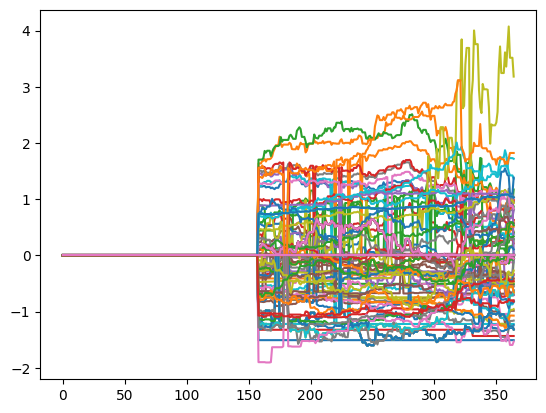

In [27]:
pd.DataFrame(sample["d"]["X_cont_hist"]).plot(legend=False)

In [31]:
sample, y = sample_nowcasting_data(
    dfs_input=df_input_valid,
    df_target=df_target_1m_pct,
    min_context=120,
    context_length=120,
    sampled_day="2009-02-14",
    country="CH",
    **tft_kwargs,
)

for freq in sample:
    print(f"frequency={freq}\n")
    print(f"Historical, continuous data: shape={sample[freq]['X_cont_hist'].shape}")
    print(f"Historical, categorical data: shape={sample[freq]['X_cat_hist'].shape}")
    print(f"Known future data: {sample[freq]['X_fut'].shape}")
    print(f"Static categorical: {sample[freq]['X_cat_stat'].shape}\n")

frequency=d

Historical, continuous data: shape=(120, 107)
Historical, categorical data: shape=(120, 6)
Known future data: (12, 1)
Static categorical: torch.Size([1])

frequency=m

Historical, continuous data: shape=(5, 113)
Historical, categorical data: shape=(5, 6)
Known future data: (12, 1)
Static categorical: torch.Size([1])

frequency=q

Historical, continuous data: shape=(2, 167)
Historical, categorical data: shape=(2, 6)
Known future data: (12, 1)
Static categorical: torch.Size([1])



In [32]:
from collections import defaultdict
from nowcastml.data.dataloader import DATA_KEYS


def prepare_data_samples(n_samples: int = 1000, **kwargs):

    "Transforms the dataset from tabular format to a dataset used for training the TFT model."
    samples = defaultdict(lambda: defaultdict(list))
    y = []

    for i in tqdm(range(n_samples)):
        sample, indiv_y = sample_nowcasting_data(**kwargs)
        for freq in sample.keys():
            for key in DATA_KEYS:
                samples[freq][key].append(
                    keras.ops.convert_to_tensor(sample[freq][key])
                )
        y.append(indiv_y)

    y = keras.ops.stack(y, axis=0)
    return samples, y

In [33]:
show_doc(prepare_data_samples, title_level=3)

---

### prepare_data_samples

>      prepare_data_samples (n_samples:int=1000, **kwargs)

*Transforms the dataset from tabular format to a dataset used for training the TFT model.*

This function serves the purpose to structure the data in a way that the TFT can ingest, while taking advantage of the number of combinations of sampled data X context size to create a larger dataset.

In [34]:
train_data = prepare_data_samples(
    n_samples=50, dfs_input=df_input_train, df_target=df_target_1m_pct, **tft_kwargs
)

valid_data = prepare_data_samples(
    n_samples=50, dfs_input=df_input_valid, df_target=df_target_1m_pct, **tft_kwargs
)

100%|██████████| 50/50 [00:00<00:00, 133.33it/s]


In [46]:
train_samples, y = train_data
# Train samples is a nested dictionary, with the outer key corresponding to the frequency
# and the inner key cooresponding to the data key (X_cat_hist, etc)


for freq, samples in train_samples.items():
    print(freq)
    for key, Y in samples.items():
        print(key, len(Y), Y[0].shape, Y[1].shape)

d
X_cont_hist 50 torch.Size([365, 107]) torch.Size([365, 107])
X_cat_hist 50 torch.Size([365, 6]) torch.Size([365, 6])
X_cat_stat 50 torch.Size([1]) torch.Size([1])
X_fut 50 torch.Size([12, 1]) torch.Size([12, 1])
m
X_cont_hist 50 torch.Size([15, 113]) torch.Size([14, 113])
X_cat_hist 50 torch.Size([15, 6]) torch.Size([14, 6])
X_cat_stat 50 torch.Size([1]) torch.Size([1])
X_fut 50 torch.Size([12, 1]) torch.Size([12, 1])
q
X_cont_hist 50 torch.Size([6, 167]) torch.Size([5, 167])
X_cat_hist 50 torch.Size([6, 6]) torch.Size([5, 6])
X_cat_stat 50 torch.Size([1]) torch.Size([1])
X_fut 50 torch.Size([12, 1]) torch.Size([12, 1])


<Axes: >

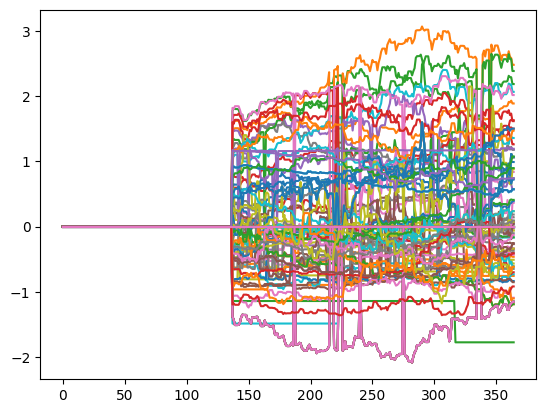

In [39]:
train_samples, y = train_data
pd.DataFrame(train_samples["d"]["X_cont_hist"][0].cpu()).plot(legend=False)

Note that the argument `max_context_length_days` cannot promise the user to reach the actual number, since there might be weekends or other dates without any information.

For models that will nowcast/forecast more than one month, the argument `delta_month` needs to be a list or an iterator as `range()`:

Now the months for which to forecast are February (the current month of the sampled day), March and April, corresponding to the three months indicated in the argument.

All historical time series in the same batch have the same length. This length varies beetween batches.

# Architecture

First, common notation is introduced, and then individual components are presented. At the end of this section, the whole model is put together.

## Notation

* unique entities: $i \in (1, \dots\, I)$
* time periods $t \in [0, T_i]$
  * $k \geq 1$ lags
  * $h \geq 1$ forecasting period
* set of entity-level static covariates: $s_i \in \mathbf{R}^{m_s}$
* set of temporal inputs: $\chi_{i, t} \in \mathbf{R}^{m_\chi}$
  * $\chi_{i,t} = [z_{i,t}, x_{i,t}]$
    * $z_{i,t} \in \mathbf{R}^{m_z}$ are historical inputs
    * $x_{i,t} \in \mathbf{R}^{m_z}$ are a priori known inputs (eg, days of the week or years that have major sports events)
  * $m_\chi$ is the number of total input variables, where $m_\chi = m_z + m_x$
* target scalars: $y_{i,t}$
  * $\hat{y}_{i,t,q} = f_q(y_{i,t-k:t}, z_{i,t-k:t}, x_{i,t-k:t+h}, s_i)$
* hidden unit size (common across all the TFT architecture for convenience): $d_{\text{model}}$
* transformed input of $j$-th variable at time $t$: $\xi_t^{(j)} \in \mathbf{R}^{d_{\text{model}}}$
  * $\Xi_t = [\xi_t^{(1)}, \dots, \xi_t^{(m_\chi)}]$

## Example data

All real data examples below use the same data from @sec-real_data.

## Dense layer

One of the fundamental units in the TFT network is the dense layer:

$$
\mathbb{Y} = \phi(\mathbf{W} x + \mathbf{b}),
$$ {#eq-dense}

where $x$ is the input data and $\mathbb{Y}$ is its output, $\phi$ is an activation function (when it is applied), $\mathbf{W} \in \mathbf{R}^{(d_{\text{size}} \times d_{\text{inputs}})}$ is a matrix of weights and $\mathbf{b} \in \mathbf{R}^{d_{size}}$ is a vector of biases.

## Input data transformations {#sec-input}

> Transforms all input variables into a latent space

All input data, regardless if historical, static or future, are transformed into a feature representation with dimension $d_{\text{model}}$. In other words, $\chi_{t}^{(j)}$, variable $j$'s observation at each time period $t$, undergoes an injective mapping $f^{(j)} : \mathbb{R} \to \mathbb{R}^{d_{\text{model}}}$ for continuous data and $f^{(j)} : \mathbb{N} \to \mathbb{R}^{d_{\text{model}}}$ for categorical data.

If the variable $\chi_{t}^{(j)}$ is continuous, this transformation is done by $d_{\text{model}}$ linear regressions, the coefficients of which are determined as part of the neural network training:

$$
\xi_t^{(j)} = \mathbf{W}^{(j)} \chi_{t}^{(j)} + \mathbf{b}^{(j)},
$$

where $\xi_t^{(j)}, \mathbf{W}^{(j)}, \mathbf{b}^{(j)} \in \mathbb{R}^{d_{\text{model}}}$. Note that $\mathbf{W}^{(j)}, \mathbf{b}^{(j)}$ are the same for variable $j$ at all time periods (ie, the layer is time-distributed).

Conversely, if the $j^{\text{th}}$ variable is categorical, then the transformation is an embedding. Each embedding layer requires a specific number of different categories, ie the cardinality of the categorical variable. This cardinality is assumed to be stable or decreasing outside of the training period; otherwise a new category would appear at testing time for which the model has not learned an embedding.

In any case, it is this embedded data, $\xi_t^{(j)}$, that is used in all the next steps of the TFT network.

See @sec-contcat for details of how the model determines which variables are continuous or categorical.

In [32]:
# | code-fold: hide


class MultiInputContEmbedding(keras.Layer):
    def __init__(self, d_model: int, **kwargs):  # Embedding size, $d_\text{model}$
        "Embeds multiple continuous variables, each with own embedding space"

        super(MultiInputContEmbedding, self).__init__(**kwargs)
        self.d_model = d_model

    def build(self, input_shape):
        super(MultiInputContEmbedding, self).build(input_shape)

        # input_shape: (batch_size, num_time_steps, num_variables)
        num_variables = input_shape[-1]

        self.kernel = self.add_weight(
            shape=(num_variables, self.d_model), initializer="uniform", name="kernel"
        )

        self.bias = self.add_weight(
            shape=(self.d_model,), initializer="zeros", name="bias"
        )

    def call(
        self, inputs  # Data of shape: (batch size, num time steps, num variables)
    ):
        "Output shape: (batch size, num time steps, num variables, d_model)"

        # Applying the linear transformation to each time step
        output = keras.ops.einsum("bti,ij->btij", inputs, self.kernel)
        output += self.bias
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2], self.d_model

In [33]:
# | output: asis
# | echo: false

show_doc(MultiInputContEmbedding.__init__, title_level=3)

---

### MultiInputContEmbedding.__init__

>      MultiInputContEmbedding.__init__ (d_model:int, **kwargs)

Embeds multiple continuous variables, each with own embedding space

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| d_model | int | Embedding size, $d_\text{model}$ |
| kwargs |  |  |

In [34]:
# | output: asis
# | echo: false

show_doc(MultiInputContEmbedding.call, title_level=3)

---

### MultiInputContEmbedding.call

>      MultiInputContEmbedding.call (inputs)

Output shape: (batch size, num time steps, num variables, d_model)

|    | **Details** |
| -- | ----------- |
| inputs | Data of shape: (batch size, num time steps, num variables) |

In [35]:
# | code-fold: show

xi_cont_hist = MultiInputContEmbedding(d_model=16)(X_cont_hist)

print(
    "Input data shape: (batch size / num time steps / num variables)", X_cont_hist.shape
)
print(
    "Encoded data shape: (batch size / num time steps / num variables / d_model)",
    xi_cont_hist.shape,
)

Input data shape: (batch size / num time steps / num variables) torch.Size([500, 120, 566])
Encoded data shape: (batch size / num time steps / num variables / d_model) torch.Size([500, 120, 566, 16])


In [36]:
# | code-fold: hide


class MultiInputCategEmbedding(keras.Layer):
    def __init__(
        self,
        d_model: int,  # Embedding size, $d_\text{model}$
        cardinalities: dict,  # Variable: cardinality in training data
        **kwargs
    ):

        "Embeds multiple categorical variables, each with own embedding function"

        super(MultiInputCategEmbedding, self).__init__(**kwargs)

        self.d_model = d_model

        self.cardinalities = cardinalities

    def build(self, input_shape):

        super(MultiInputCategEmbedding, self).build(input_shape)

        if len(self.cardinalities.keys()) != input_shape[-1]:

            raise ValueError(
                "`cardinalities` should have as many elements as the input data's variables."
            )

        self.embed_layer = {
            var: keras.Sequential(
                [
                    layers.Embedding(
                        input_dim=cardin,
                        output_dim=self.d_model,
                        mask_zero=True,
                        name="input_embed_" + var.replace(" ", "_"),
                    )
                ]
            )
            for var, cardin in self.cardinalities.items()
        }

        super(MultiInputCategEmbedding, self).build(input_shape)

    def call(
        self, inputs  # Data of shape: (batch size, num time steps, num variables)
    ):

        "Output shape: (batch size, num time steps, num variables, d_model)"

        embeds = [
            self.embed_layer[var](inputs[:, :, idx])
            for idx, var in enumerate(self.cardinalities.keys())
        ]

        return keras.ops.stack(embeds, axis=2)  # keras.ops.concatenate(embeds, axis=-1)

In [37]:
# | output: asis
# | echo: false

show_doc(MultiInputCategEmbedding.__init__, title_level=3)

---

### MultiInputCategEmbedding.__init__

>      MultiInputCategEmbedding.__init__ (d_model:int, cardinalities:dict,
>                                         **kwargs)

Embeds multiple categorical variables, each with own embedding function

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| d_model | int | Embedding size, $d_\text{model}$ |
| cardinalities | dict | Variable: cardinality in training data |
| kwargs |  |  |

In [38]:
# | output: asis
# | echo: false

show_doc(MultiInputCategEmbedding.call, title_level=3)

---

### MultiInputCategEmbedding.call

>      MultiInputCategEmbedding.call (inputs)

Output shape: (batch size, num time steps, num variables, d_model)

|    | **Details** |
| -- | ----------- |
| inputs | Data of shape: (batch size, num time steps, num variables) |

Note that this function masks out the data whenever categories are set to zero. This is to ensure that the model can take in variable-sized inputs. Because of this, the model requires inputted categorical data to be added 1 whenever zero is a possible category.

> Note to self: I don't like the approach above where we rely implicitly on the input data's ordering to extract the cardinality. But this is a practical way to get things going. It should be changed to a more robust in the future.

In [39]:
# | code-fold: show

xi_cat_hist = MultiInputCategEmbedding(d_model=16, cardinalities=cardin_hist)(
    X_cat_hist
)

print(
    "Input data shape: (batch size / num time steps / num variables)", X_cat_hist.shape
)
print(
    "Encoded data shape: (batch size / num time steps / num variables / d_model)",
    xi_cat_hist.shape,
)

Input data shape: (batch size / num time steps / num variables) torch.Size([500, 120, 6])
Encoded data shape: (batch size / num time steps / num variables / d_model) torch.Size([500, 120, 6, 16])


In [40]:
# | code-fold: show

xi_cat_fut = MultiInputCategEmbedding(
    d_model=16,
    cardinalities={
        "Month of Year": 12 + 1
    },  # hardcoded because it is always just the months in an year
)(X_cat_fut)

print(
    "Input data shape: (batch size / num time steps / num variables)", X_cat_fut.shape
)
print(
    "Encoded data shape: (batch size / num time steps / num variables / d_model)",
    xi_cat_fut.shape,
)
print(keras.ops.any(keras.ops.isnan(xi_cat_fut)))

Input data shape: (batch size / num time steps / num variables) torch.Size([500, 12, 1])
Encoded data shape: (batch size / num time steps / num variables / d_model) torch.Size([500, 12, 1, 16])
tensor(False)


In [41]:
keras.ops.expand_dims(X_cat_stat, axis=-1).shape

torch.Size([500, 1, 1, 1])

In [42]:
# | code-fold: show

xi_stat = MultiInputCategEmbedding(d_model=16, cardinalities=cardin_stat)(X_cat_stat)

print(
    "Input data shape: (batch size / num time steps / num variables)", X_cat_stat.shape
)
print(
    "Encoded data shape: (batch size / num time steps (=one) / num variables / d_model)",
    xi_stat.shape,
)
print(keras.ops.any(keras.ops.isnan(xi_stat)))

Input data shape: (batch size / num time steps / num variables) torch.Size([500, 1, 1])
Encoded data shape: (batch size / num time steps (=one) / num variables / d_model) torch.Size([500, 1, 1, 16])
tensor(False)


In [43]:
# | code-fold: hide


class InputTFT(keras.Layer):

    def __init__(self, d_model: int = 16, **kwargs):  # Embedding size, $d_\text{model}$

        "Input layer for the Temporal Fusion Transformer model"

        super(InputTFT, self).__init__(**kwargs)
        self.d_model = d_model

        self.flat = layers.Flatten()

        self.concat = layers.Concatenate(axis=2)

    def build(self, input_shape):

        self.cont_hist_embed = MultiInputContEmbedding(
            self.d_model, name="embed_continuous_historical_vars"
        )

        self.cat_hist_embed = MultiInputCategEmbedding(
            self.d_model, cardinalities=cardin_hist, name="embed_categ_historical_vars"
        )

        self.cat_fut_embed = MultiInputCategEmbedding(
            self.d_model,
            # Note below the same categorical variables are just the months in an year.
            # This situation may not apply to all cases.
            # More complex models using other categorical future known data might require
            # another cardinalities dictionary.
            cardinalities={"Month of Year": 13},
            name="embed_categ_knownfuture_vars",
        )

        self.cat_stat_embed = MultiInputCategEmbedding(
            self.d_model, cardinalities=cardin_stat, name="embed_categ_static_vars"
        )

        super(InputTFT, self).build(input_shape)

    def call(
        self,
        # List of data with shape: [(batch size, num hist time steps, num continuous hist variables), (batch size, num hist time steps, num categorical hist variables), (batch size, num static variables), (batch size, num future time steps, num categorical future variables)]
        input: list,
    ):
        """List of output with shape: [









            (batch size, num hist time steps, num historical variables, d_model),









            (batch size, num future time steps, num future variables, d_model)









            (batch size, one, num static variables, d_model),









        ]"""
        cont_hist, cat_hist, cat_fut, cat_stat = input

        if len(cat_stat.shape) == 2:

            cat_stat = keras.ops.expand_dims(cat_stat, axis=-1)

        cont_hist = self.cont_hist_embed(cont_hist)

        # cont_hist = keras.ops.swapaxes(cont_hist, axis1=2, axis2=3)

        cat_hist = self.cat_hist_embed(cat_hist)

        # cat_hist = self.flat(cat_hist)

        cat_fut = self.cat_fut_embed(cat_fut)

        # cat_fut = self.flat(cat_fut)

        cat_stat = self.cat_stat_embed(cat_stat)

        # cat_stat = self.flat(cat_stat)

        # (batch size / (num time steps * (num historical + future variables) + num static variables) * embedding size)

        hist = self.concat([cont_hist, cat_hist])

        return hist, cat_fut, cat_stat

In [44]:
# | output: asis
# | echo: false

show_doc(InputTFT.__init__, title_level=3)

---

### InputTFT.__init__

>      InputTFT.__init__ (d_model:int=16, **kwargs)

Input layer for the Temporal Fusion Transformer model

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d_model | int | 16 | Embedding size, $d_\text{model}$ |
| kwargs |  |  |  |

In [45]:
# | output: asis
# | echo: false

show_doc(InputTFT.call, title_level=3)

---

### InputTFT.call

>      InputTFT.call (input:list)

List of output with shape: [
    (batch size, num hist time steps, num historical variables, d_model),
    (batch size, num future time steps, num future variables, d_model)
    (batch size, one, num static variables, d_model),
]

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| input | list | List of data with shape: [(batch size, num hist time steps, num continuous hist variables), (batch size, num hist time steps, num categorical hist variables), (batch size, num static variables), (batch size, num future time steps, num categorical future variables)] |

In [46]:
# | code-fold: show

xi_hist, xi_fut, xi_stat = InputTFT()([X_cont_hist, X_cat_hist, X_cat_fut, X_cat_stat])
print(
    "Encoded historical data shape: (batch size / num hist time steps / num historical variables / d_model)",
    xi_hist.shape,
)
print(
    "Encoded historical data shape: (batch size / num future time steps / num future variables / d_model)",
    xi_fut.shape,
)
print(
    "Encoded historical data shape: (batch size / one / num static variables / d_model)",
    xi_stat.shape,
)

Encoded historical data shape: (batch size / num hist time steps / num historical variables / d_model) torch.Size([500, 120, 572, 16])
Encoded historical data shape: (batch size / num future time steps / num future variables / d_model) torch.Size([500, 12, 1, 16])
Encoded historical data shape: (batch size / one / num static variables / d_model) torch.Size([500, 1, 1, 16])


**From now on, whenever relevant the examples with real data will use the $\xi$ elements created above.**

The following simplistic model shows how the input layer is used. The goal is to highlight how the data is inputted into a TFT model, by not focusing on its complexity just now.

First, it takes up the data. Then, in this simplified model it flattens all inputs and uses a dense layer connected to all embeddings at all time points to output the forecast.

## Skip connection

> Adds inputs to layer and then implements layer normalisation

$$
\text{LayerNorm}(a + b),
$$ {#eq-skip}

for $a$ and $b$ tensors of the same dimension and $\text{LayerNorm}(\cdot)$ being the layer normalisation (@ba2016layer), ie subtracting $\mu^l$ and dividing by $\sigma^l$ defined as:

$$
\mu^l = \frac{1}{H} \sum_{i=1}^H n_i^l \quad \sigma^l = \sqrt{\frac{1}{H} \sum_{i=1}^H (n_i^l - \mu^l)^2},
$$ {#eq-layernorm}

with $H$ denoting the number of $n$ hidden units in a layer $l$.

* Adding a layer's inputs to its outputs is also called "skip connection"
* The layer is then normalised [@ba2016layer] to avoid having the numbers grow too big, which is detrimental for gradient transmission
  * Layer normalisation uses the same computation both during training and inference times, and is particularly suitable for time series

## Gated linear unit (GLU)

> Linear layer that learns how much to gate vs let pass through

Using input $\gamma \in \mathbb{R}^{d_{\text{model}}}$ and the subscript $\omega$ to index weights, 

$$
\text{GLU}_{\omega}(\gamma) = \sigma(W_{4, \omega} \gamma + b_{4, \omega}) \odot (W_{5, \omega} \gamma + b_{5, \omega}),
$$ {#eq-GLU}

where $\mathbf{W} \in \mathbf{R}^{(d_{\text{model}} \times d_{\text{model}})}$ is a matrix of weights and $\mathbf{b} \in \mathbf{R}^{d_{model}}$ is a vector of biases. Importantly, $\mathbf{W}$ and $\mathbf{b}$ are indexed with $_{\omega}$ to denote weight-sharing (within each variable) when the layer is time-distributed.

@dauphin2017language introduced GLUs. Their intuition is to train two versions of a dense layer in the same data, but one of them having a sigmoid activation (which outputs values between zero and one), then multiplying each hidden unit.

The result could be zero or very close to zero through the Hadamard multipliciation, which in practice means that the network would not be affected by that data (ie, the data $\gamma$ would be gated out). The first term, with the sigmoid, is the gate that determines what percentage of the linear layer passes through.

According to @lim2021temporal, GLUs:

* *"... reduce the vanishing gradient problem for deep architectures by providing a linear path for gradients while retaining non-linear capabilities"* and
* *"... provide flexibility to suppress any parts of the architecture that are not required for a given dataset"*

The GLU is a key part of the Gated Residual Network, described in @sec-GRN.

In [47]:
# | code-fold: hide


class GatedLinearUnit(keras.Layer):
    def __init__(
        self,
        d_model: int = 16,  # Embedding size, $d_\text{model}$
        dropout_rate: float | None = None,  # Dropout rate
        use_time_distributed: bool = True,  # Apply the GLU across all time steps?
        activation: str | callable = None,  # Activation function
        **kwargs
    ):
        "Gated Linear Unit dynamically gates input data"
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.use_time_distributed = use_time_distributed
        self.activation = activation

    def build(self, input_shape):
        super(GatedLinearUnit, self).build(input_shape)
        self.dropout = (
            layers.Dropout(self.dropout_rate) if self.dropout_rate is not None else None
        )
        self.activation_layer = layers.Dense(self.d_model, activation=self.activation)
        self.gate_layer = layers.Dense(self.d_model, activation="sigmoid")
        self.multiply = layers.Multiply()

        if self.use_time_distributed:
            self.activation_layer = layers.TimeDistributed(self.activation_layer)
            self.gate_layer = layers.TimeDistributed(self.gate_layer)

    def call(self, inputs, training=None):
        """List of outputs with shape: [
            (batch size, ..., d_model),
            (batch size, ..., d_model)
        ]"""
        if self.dropout is not None and training:
            inputs = self.dropout(inputs)

        activation_output = self.activation_layer(inputs)
        gate_output = self.gate_layer(inputs)
        return self.multiply([activation_output, gate_output]), gate_output

    def get_config(self):
        config = super(GatingLayer, self).get_config()
        config.update(
            {
                "d_model": self.d_model,
                "dropout_rate": self.dropout_rate,
                "use_time_distributed": self.use_time_distributed,
                "activation": self.activation,
            }
        )
        return config

In [48]:
# | output: asis
# | echo: false

show_doc(GatedLinearUnit.__init__, title_level=3)

---

### GatedLinearUnit.__init__



Gated Linear Unit dynamically gates input data

In [49]:
# | output: asis
# | echo: false

show_doc(GatedLinearUnit.call, title_level=3)

---

### GatedLinearUnit.call

>      GatedLinearUnit.call (inputs, training=None)

List of outputs with shape: [
    (batch size, ..., d_model),
    (batch size, ..., d_model)
]

In [50]:
# | code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100
d_model = 16

# input dimensions: batches / timesteps / features
x = np.random.randn(batch_size * n_timesteps * n_features).reshape(
    [batch_size, n_timesteps, n_features]
)

# output dimensions: batches / timesteps / d_model
print(
    "GLU output shape: (batch size / num time steps / embedding dim)",
    GatedLinearUnit(d_model=16)(x)[0].shape,
)
print(
    "GLU gate shape: (batch size / num time steps / embedding dim)",
    GatedLinearUnit(d_model=16)(x)[1].shape,
)

GLU output shape: (batch size / num time steps / embedding dim) torch.Size([3, 5, 16])
GLU gate shape: (batch size / num time steps / embedding dim) torch.Size([3, 5, 16])


In [51]:
# | code-fold: show

# output dimensions: batches / num time steps / num variables / d_model

glu = GatedLinearUnit()
gated_linear, gate = glu(xi_hist[:10, Ellipsis])
print("GLU input shape: ", xi_hist[:10, Ellipsis].shape)
print("GLU output shape: ", gated_linear.shape)
print("GLU gate shape:", gate.shape)

GLU input shape:  torch.Size([10, 120, 572, 16])
GLU output shape:  torch.Size([10, 120, 572, 16])
GLU gate shape: torch.Size([10, 120, 572, 16])


## Gated residual network (GRN) {#sec-GRN}

$$
\text{GRN}_{\omega}(a, c) = \text{LayerNorm}(a + \text{GLU}_{\omega}(W_{1, \omega} \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c) + b_{1, w}))
$$ {#eq-GRN}

* Breaking down $\text{GRN}_{\omega}(a, c)$:
    * *1st step*: $\eta_{2} = \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c)$ (where the additional context $c$ might be zero) as in @eq-dense but adapted for the added context if any and with $\text{ELU}(\cdot)$ as the activation function,
    * *2nd step*: $\eta_{1} = W_{1, \omega} \eta_{2} + b_{1, w}$ as in @eq-dense,
    * *3rd step*: $\text{LayerNorm}(a + \text{GLU}_{\omega}(\eta_{1}))$ as in @eq-skip and @eq-GLU
* $\text{ELU}(\cdot)$ is the Exponential Linear Unit activation function (@clevert2015fast)
    * Unlike ReLUs, ELUs allow for negative values, which pushes unit activations closer to zero at a lower computation complexity, and producing more accurate results
* The GRN is a key building block of the TFT
    * Helps keep information only from relevant input variables
    * Also keeps the model as simple as possible by only applying non-linearities when relevant

Note that the GRN can take all types of time series inputs, ie continuous historical, categorical historical and categorical future, but not categorical static data.

In [52]:
# | code-fold: hide


class GatedResidualNetwork(keras.layers.Layer):
    def __init__(
        self,
        d_model: int = 16,  # Embedding size, $d_\text{model}$
        output_size=None,
        dropout_rate=None,
        use_time_distributed=True,
        **kwargs
    ):
        "Gated residual network"
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.d_model = d_model
        self.output_size = output_size if output_size is not None else d_model
        self.dropout_rate = dropout_rate
        self.use_time_distributed = use_time_distributed

    def build(self, input_shape):
        super(GatedResidualNetwork, self).build(input_shape)
        self.dense = layers.Dense(self.output_size)
        self.hidden_dense = layers.Dense(self.d_model)
        self.hidden_activation = layers.Activation("elu")
        self.context_dense = layers.Dense(self.d_model, use_bias=False)
        self.gating_layer = GatedLinearUnit(
            d_model=self.output_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=self.use_time_distributed,
            activation=None,
        )
        self.add = layers.Add()
        self.l_norm = layers.LayerNormalization()

        if self.use_time_distributed:
            self.dense = layers.TimeDistributed(self.dense)
            self.hidden_dense = layers.TimeDistributed(self.hidden_dense)
            self.context_dense = layers.TimeDistributed(self.context_dense)

    def call(self, inputs, additional_context=None, training=None):
        # Setup skip connection
        skip = self.dense(inputs) if self.output_size != self.d_model else inputs

        # 1st step: eta2
        hidden = self.hidden_dense(inputs)

        # Context handling
        if additional_context is not None:
            hidden += self.context_dense(additional_context)

        hidden = self.hidden_activation(hidden)

        # 2nd step: eta1 and 3rd step
        gating_layer, gate = self.gating_layer(hidden)

        # Final step
        GRN = self.add([skip, gating_layer])
        GRN = self.l_norm(GRN)

        return GRN, gate

    def get_config(self):
        config = super(GatedResidualNetwork, self).get_config()
        config.update(
            {
                "d_model": self.d_model,
                "output_size": self.output_size,
                "dropout_rate": self.dropout_rate,
                "use_time_distributed": self.use_time_distributed,
            }
        )
        return config

In [53]:
# | output: asis
# | echo: false

show_doc(GatedResidualNetwork.__init__, title_level=3)

---

### GatedResidualNetwork.__init__

>      GatedResidualNetwork.__init__ (d_model:int=16, output_size=None,
>                                     dropout_rate=None,
>                                     use_time_distributed=True, **kwargs)

Gated residual network

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d_model | int | 16 | Embedding size, $d_\text{model}$ |
| output_size | NoneType | None |  |
| dropout_rate | NoneType | None |  |
| use_time_distributed | bool | True |  |
| kwargs |  |  |  |

In [54]:
# | output: asis
# | echo: false

show_doc(GatedResidualNetwork.call, title_level=3)

---

### GatedResidualNetwork.call

>      GatedResidualNetwork.call (inputs, additional_context=None,
>                                 training=None)

In [55]:
# | code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 16
d_model = 16

# input dimensions: batches / timesteps / features
x = np.random.randn(batch_size * n_timesteps * n_features).reshape(
    [batch_size, n_timesteps, n_features]
)

grn = GatedResidualNetwork(d_model=d_model)

output, gate = grn(x)

# output dimensions: batches / timesteps / d_model
print("GRN output shape: ", output.shape)
print("GRN gate shape: ", gate.shape)
# assert grn.shape == [batch_size, n_timesteps, output_size]

GRN output shape:  torch.Size([3, 5, 16])
GRN gate shape:  torch.Size([3, 5, 16])


The example below uses transformed data $\xi_t^{(j)}$ for $j=0$ as an example.

In [56]:
# | code-fold: show

grn = GatedResidualNetwork()
output, gate = grn(xi_hist[:, :, 0, :])

# output dimensions: batches / timesteps / d_model (`output_size`)
output.shape, [
    xi_hist[:, :, 0, :].shape[0],
    xi_hist[:, :, 0, :].shape[1],
    d_model,
], gate.shape, [xi_hist[:, :, 0, :].shape[0], xi_hist[:, :, 0, :].shape[1], d_model]

(torch.Size([500, 120, 16]),
 [500, 120, 16],
 torch.Size([500, 120, 16]),
 [500, 120, 16])

## Variable selection networks

$$
\sum_{j=1}^{m_{\chi}} \upsilon_{\chi_t}^{(j)} \tilde{\xi}_t^{(j)},
$$ {#eq-VSN}

with $j$ indexing the input variable and $m$ being the number of features, $\upsilon_{\chi_t}^{(j)}$ standing for variable $j$'s selection weight, and $\tilde{\xi}_t^{(j)}$ defined as:

$$
\tilde{\xi}_t^{(j)} = \text{GRN}(\xi_t^{(j)}).
$$ {#eq-embed}

* In the paper, they are represented in the bottom right of Fig. 2
* Note there are separate variable selection networks for different input groups:
  * `static_variable_selection`
    * does not have static context as input, it already *is* the static information
  * `temporal_variable_selection`
    * used for both historical and known future inputs
    * includes static contexts
* Both of these functions take the result of the transformed data, ie embeddings for categorical variables and a linear layer for continuous variables
  * static variables are always categorical
  * temporal variables can be either categorical or continuous
  * in any case, following @lim2021temporal, the resulting transformation is expected to have the same dimension as `d_model`

In [57]:
class StaticVariableSelection(keras.Layer):
    def __init__(
        self,
        d_model: int = 16,  # Embedding size, $d_\text{model}$
        dropout_rate: float = 0.0,
        **kwargs
    ):
        "Static variable selection network"
        super(StaticVariableSelection, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout_rate = dropout_rate

        # Define GRNs for the transformed embeddings
        self.grns_transformed_embeddings = []  # This will be a list of GRN layers

        self.flat = layers.Flatten()
        self.softmax = layers.Activation("softmax")
        self.mult = layers.Multiply()

    def build(self, input_shape):
        super(StaticVariableSelection, self).build(input_shape)

        num_static = input_shape[2]

        # Define the GRN for the sparse weights
        self.grn_sparse_weights = GatedResidualNetwork(
            d_model=self.d_model, output_size=num_static, use_time_distributed=False
        )

        for i in range(num_static):
            # Create a GRN for each static variable
            self.grns_transformed_embeddings.append(
                GatedResidualNetwork(self.d_model, use_time_distributed=False)
            )

    def call(self, inputs, training=None):
        _, _, num_static, _ = (
            inputs.shape
        )  # batch size / one time step (since it's static) / num static variables / d_model

        flattened = self.flat(inputs)

        # Compute sparse weights
        grn_outputs, _ = self.grn_sparse_weights(flattened, training=training)
        sparse_weights = self.softmax(grn_outputs)
        sparse_weights = keras.ops.expand_dims(sparse_weights, axis=-1)

        # Compute transformed embeddings
        transformed_embeddings = []
        for i in range(num_static):
            embed, _ = self.grns_transformed_embeddings[i](
                inputs[:, 0, i : i + 1, :], training=training
            )
            transformed_embeddings.append(embed)
        transformed_embedding = keras.ops.concatenate(transformed_embeddings, axis=1)

        # Combine with sparse weights
        combined = self.mult([sparse_weights, transformed_embedding])
        static_vec = keras.ops.sum(combined, axis=1)

        return static_vec, sparse_weights

    def get_config(self):
        config = super(StaticVariableSelectionLayer, self).get_config()
        config.update({"d_model": self.d_model, "dropout_rate": self.dropout_rate})
        return config

In [58]:
# | code-fold: show
# | output: asis

show_doc(StaticVariableSelection.__init__, title_level=3)

---

### StaticVariableSelection.__init__

>      StaticVariableSelection.__init__ (d_model:int=16, dropout_rate:float=0.0,
>                                        **kwargs)

Static variable selection network

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d_model | int | 16 | Embedding size, $d_\text{model}$ |
| dropout_rate | float | 0.0 |  |
| kwargs |  |  |  |

In [59]:
# | code-fold: show
# | output: asis

show_doc(StaticVariableSelection.call, title_level=3)

---

### StaticVariableSelection.call

>      StaticVariableSelection.call (inputs, training=None)

In [60]:
# | code-fold: show
# | warning: false

svars = StaticVariableSelection()
static_vars, static_selection_weights = svars(xi_stat)

print(
    "xi_t shape: batch size / num time steps (=one) / number of categorical static variables / embedding size",
    xi_stat.shape,
)
print(
    "Sum of the embeddings of selected variables shape: batch size / embedding size",
    static_vars.shape,
)
print(
    "Selection weights shape: batch size / number of categorical static variables / one",
    static_selection_weights.shape,
)

xi_t shape: batch size / num time steps (=one) / number of categorical static variables / embedding size torch.Size([500, 1, 1, 16])
Sum of the embeddings of selected variables shape: batch size / embedding size torch.Size([500, 16])
Selection weights shape: batch size / number of categorical static variables / one torch.Size([500, 1, 1])


In [61]:
# | code-fold: hide


class TemporalVariableSelection(keras.Layer):

    def __init__(
        self,
        d_model: int = 16,  # Embedding size, $d_\text{model}$
        dropout_rate: float = 0.0,
        **kwargs
    ):

        "Temporal variable selection"

        super(TemporalVariableSelection, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout_rate = dropout_rate

        self.mult = layers.Multiply()

    def build(self, input_shape):

        super(TemporalVariableSelection, self).build(input_shape)

        self.batch_size, self.time_steps, self.num_input_vars, self.d_model = (
            input_shape[0]
        )

        self.var_sel_weights = GatedResidualNetwork(
            d_model=self.d_model,
            output_size=self.num_input_vars,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
        )

        self.softmax = layers.Activation("softmax")

        # Create a GRN for each temporal variable

        self.grns_transformed_embeddings = GatedResidualNetwork(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
        )

    def call(
        self, inputs, training=None  # List of temporal embeddings, static context
    ):

        temporal_embeddings, static_context = inputs

        flattened_embed = keras.ops.reshape(
            temporal_embeddings,
            [-1, self.time_steps, self.num_input_vars * self.d_model],
        )

        parallel_variables = keras.ops.reshape(
            temporal_embeddings, [-1, self.time_steps, self.d_model]
        )  # tensor is shaped this way so that a GRN can be applied to each variable of each batch

        c_s = keras.ops.expand_dims(static_context, axis=1)

        # variable weights

        grn_outputs, _ = self.var_sel_weights(flattened_embed, c_s, training=training)

        variable_weights = self.softmax(grn_outputs)

        variable_weights = keras.ops.expand_dims(variable_weights, axis=2)

        # variable combination

        # transformed_embeddings = [

        #     grn_layer(temporal_embeddings[:, :, i, :], training=training)[0]

        #     for i, grn_layer in enumerate(self.grns_transformed_embeddings)

        # ]

        transformed_embeddings, _ = self.grns_transformed_embeddings(
            parallel_variables, training=training
        )

        transformed_embeddings = keras.ops.reshape(
            transformed_embeddings,
            [-1, self.time_steps, self.num_input_vars, self.d_model],
        )

        # transformed_embeddings = keras.ops.stack(transformed_embeddings, axis=2)

        temporal_vec = keras.ops.einsum(
            "btij,btjk->btk", variable_weights, transformed_embeddings
        )

        return temporal_vec, keras.ops.squeeze(variable_weights, axis=2)

In [62]:
# | code-fold: show
# | output: asis

show_doc(TemporalVariableSelection.__init__, title_level=3)

---

### TemporalVariableSelection.__init__

>      TemporalVariableSelection.__init__ (d_model:int=16,
>                                          dropout_rate:float=0.0, **kwargs)

Temporal variable selection

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d_model | int | 16 | Embedding size, $d_\text{model}$ |
| dropout_rate | float | 0.0 |  |
| kwargs |  |  |  |

In [63]:
# | code-fold: show
# | output: asis

show_doc(TemporalVariableSelection.call, title_level=3)

---

### TemporalVariableSelection.call

>      TemporalVariableSelection.call (inputs, training=None)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| inputs |  |  | List of temporal embeddings, static context |
| training | NoneType | None |  |

The main input to `temporal_variable_selection` are the transformed *temporal* variables $\xi_t^{(j)}$.

The selection of the temporal variables also requires the context from the static variables $c_s$, created below by passing `static_vars`, the output from the static variable selection unit (see @eq-static_var_sel), into a GRN.

In [64]:
# | code-fold: show

# static context c_s
svars = StaticVariableSelection()
xi_stat_selected, _ = svars(xi_stat)
static_context_grn = GatedResidualNetwork(use_time_distributed=False)
c_s, _ = static_context_grn(xi_stat_selected)

# variable selection, historical data
tvars_hist = TemporalVariableSelection()
hist_sel, hist_weights = tvars_hist(
    [xi_hist[:, :, :5, :], c_s]
)  # only the first five variables to keep it quick
print(
    "Temporal variables feature shape: (batch size, num time steps, d_model)",
    hist_sel.shape,
)
print(
    "Temporal variables weights shape: (batch size, num time steps, num variables (5))",
    hist_weights.shape,
)

# variable selection, future data
tvars_fut = TemporalVariableSelection()
fut_sel, fut_weights = tvars_fut([xi_fut, c_s])
print(
    "Temporal variables feature shape: (batch size, num time steps, d_model)",
    fut_sel.shape,
)
print(
    "Temporal variables weights shape: (batch size, num time steps, num variables)",
    fut_weights.shape,
)

Temporal variables feature shape: (batch size, num time steps, d_model) torch.Size([500, 120, 16])
Temporal variables weights shape: (batch size, num time steps, num variables (5)) torch.Size([500, 120, 5])
Temporal variables feature shape: (batch size, num time steps, d_model) torch.Size([500, 12, 16])
Temporal variables weights shape: (batch size, num time steps, num variables) torch.Size([500, 12, 1])


## Sequence-to-sequence layer (LSTM)

This  the `TemporalFeatures` layer implements the following transformation:

$$ \text{LSTM} :
\tilde{\xi}_{t-k:t}, \tilde{\xi}_{t:\tau_{\text{max}}} \in \mathbb{R}^{k + \tau_{\text{max}} X d_{\text{model}}} \to \phi(t, n) \in \mathbb{R}^{k + \tau_{\text{max}} X d_{\text{model}}}, n \in [-k, \tau_{\text{max}}],
$$ {#eq-seqtoseq}

where the starting cell and hidden states of $\text{LSTM}_{t-k:t}$ are $c_c$ and $c_h$, each calculated as $c_p = GRN(\xi^{(j)}), p \in (c, h)$ and $j$ denoting static variables.

Finally, the `TemporalFeatures` layer compares the input data $\tilde{\xi}_{t-k:\tau_{\text{max}}}$ with the non-linear transformation $\phi(t, n)$, as follows:

$$
\tilde{\phi}(t, n) = \text{LayerNorm}(\tilde{\xi}_{t+n} + \text{GLU}_{\tilde{\phi}}(\phi(t, n))).
$$

In [65]:
class TemporalFeatures(keras.Layer):
    def __init__(
        self,
        d_model: int = 16,  # Embedding size, $d_\text{model}$
        dropout_rate: float = 0.0,  # Dropout rate
        **kwargs
    ):
        super(TemporalFeatures, self).__init__(**kwargs)
        self.d_model = d_model
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        super(TemporalFeatures, self).build(input_shape)
        self.hist_encoder = layers.LSTM(
            units=self.d_model,
            return_sequences=True,
            return_state=True,
            stateful=False,
            activation="tanh",
            recurrent_activation="sigmoid",
            recurrent_dropout=self.dropout_rate,
            unroll=False,
            use_bias=True,
        )
        self.fut_decoder = layers.LSTM(
            units=self.d_model,
            return_sequences=True,
            return_state=False,
            stateful=False,
            activation="tanh",
            recurrent_activation="sigmoid",
            recurrent_dropout=self.dropout_rate,
            unroll=False,
            use_bias=True,
        )
        self.lstm_glu = GatedLinearUnit(
            d_model=self.d_model,  # Dimension of the GLU
            dropout_rate=self.dropout_rate,  # Dropout rate
            use_time_distributed=True,  # Apply the GLU across all time steps?
            activation=None,  # Activation function
        )
        self.add = layers.Add()
        self.l_norm = layers.LayerNormalization()

    def call(self, inputs, training=None):
        historical_features, future_features, c_h, c_c = inputs
        input_embeddings = keras.ops.concatenate(
            [historical_features, future_features], axis=1
        )

        history_lstm_encoder, state_h, state_c = self.hist_encoder(
            historical_features,
            initial_state=[c_h, c_c],  # short-term state  # long-term state
            training=training,
        )

        future_lstm_decoder = self.fut_decoder(
            future_features,
            initial_state=[state_h, state_c],  # short-term state  # long-term state
            training=training,
        )

        # this step concatenates at the time dimension, ie
        # the time series of history internal states are now
        # concated in sequence with the series of future internal states
        # $\phi(t,n) \in \{\phi(t,-k), \dots, \phi(t, \tau_{\text{max}})\}$
        lstm_layer = keras.ops.concatenate(
            [history_lstm_encoder, future_lstm_decoder], axis=1
        )

        # Apply gated skip connection
        lstm_layer, _ = self.lstm_glu(lstm_layer, training=training)
        outputs = self.add([lstm_layer, input_embeddings])
        outputs = self.l_norm(outputs)
        # it's the temporal feature layer that is fed into the Temporal Fusion Decoder
        # its dimensions are (batch size / num time steps historical + future / hidden size)

        return outputs

In [66]:
temp_feat = TemporalFeatures()

In [67]:
# | output: asis
# | echo: false

show_doc(TemporalFeatures.__init__, title_level=3)

---

### TemporalFeatures.__init__

>      TemporalFeatures.__init__ (d_model:int=16, dropout_rate:float=0.0,
>                                 **kwargs)

Initializes internal Module state, shared by both nn.Module and ScriptModule.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d_model | int | 16 | Embedding size, $d_\text{model}$ |
| dropout_rate | float | 0.0 | Dropout rate |
| kwargs |  |  |  |

In [68]:
# | output: asis
# | echo: false

show_doc(TemporalFeatures.call, title_level=3)

---

### TemporalFeatures.call

>      TemporalFeatures.call (inputs, training=None)

The graph below plots the temporal futures resulting from the function above, using the first batch of data as an example. Each curve is the time series of one element of the embedding vector, which in turn contains all the relevant information from the time-varying inputs, both categorical and continuous, after being filtered by the network. The black vertical line marks the point at which the temporal futures is relying on future known information.

Note that even with these randomly initiated LSTM layers, it is already possible to see the obvious fact that the information content from historical input (left to the vertical line) is different compared to the known future data (ie, information from the dates; to the right of the vertical line).

Still, the future part has *some* information, which might be useful in nowcasting or predicting inflation farther out.

## Static enrichment

This step is responsible for adding static information on the country for which inflation is being nowcasted to the temporal features.

This is achieved by a GRN layer as follows:

$$
\theta(t, n) = \text{GRN}_{\theta}(\tilde{\phi}(t, n), c_e)
$$

## Attention components

* Attention mechanisms use relationships between keys $K \in \mathbf{R}^{N \times d_{attention}}$ and queries $Q \in \mathbf{R}^{N \times d_{attention}}$ to scale a vector of values $V \in \mathbf{R}^{N \times d_V}$: $\text{Attention}(Q, K, V) = A(Q, K) V$
    * $N$ is the number of timesteps going into the attention layer (the number of lags $k$ plus the number of periods to be forecasted $\tau_{\text{max}}$)
    * $A(\cdot)$ is a normalisation function
        * After @vaswani2017attention, the canonical choice for $A(\cdot)$ is the scaled dot-product: $A(Q, K) = \text{Softmax}(\frac{Q K^{T}}{\sqrt{d_{attention}}} )$
    
* The TFT uses a modified attention head to enhance the explainability of the model
* Specifically, the transformer block (multi-head attention) is modified to:
    * share values in each head, and
    * employ additive aggregation of all heads
* More formally, compare the interpretable multi-head attention (used in this paper) with the canonical multi-head attention:
    * $\text{InterpretableMultiHead}(Q, K, V) = \tilde{H} W_{H}$, with:
        * $\begin{aligned}\tilde{H} &= \tilde{A}(Q, K) V W_V \\
        &= \{\frac{1}{m_H} \sum^{m_{H}}_{h=1} A(Q W^{(h)}_Q, K W^{(h)}_K) \} V W_V \\
        &= \frac{1}{m_H} \sum^{m_{H}}_{h=1} \text{Attention}(Q W^{(h)}_Q, K W^{(h)}_K, V W_V)
        \end{aligned}$
    * $\text{MultiHead}(Q, K, V) = [H_1, \dots, H_{m_H}] W_H$, with:
        * $H_h = \text{Attention}(Q W^{(h)}_Q, K W^{(h)}_K, V W_V^{(h)}) $

### Decoder mask for self-attention layer

In [69]:
def get_decoder_mask(self_attention_inputs):  # Inputs to the self-attention layer
    "Determines shape of decoder mask"
    len_s = keras.ops.shape(self_attention_inputs)[1]  # length of inputs
    bs = keras.ops.shape(self_attention_inputs)[0]  # batch shape
    mask = keras.ops.cumsum(keras.ops.eye(len_s), axis=0)

    ### warning: I had to manually implement some batch-wise shape here
    ### because the new keras `eye` function does not have a batch_size arg.
    ### inspired by: https://github.com/tensorflow/tensorflow/blob/v2.14.0/tensorflow/python/ops/linalg_ops_impl.py#L30
    ### <hack>
    mask = keras.ops.expand_dims(mask, axis=0)
    mask = keras.ops.tile(mask, (bs, 1, 1))
    ### </hack>

    return mask

In [70]:
# | output: asis
# | echo: false

show_doc(get_decoder_mask, title_level=3)

---

### get_decoder_mask

>      get_decoder_mask (self_attention_inputs)

Determines shape of decoder mask

|    | **Details** |
| -- | ----------- |
| self_attention_inputs | Inputs to the self-attention layer |

In [71]:
# | code-fold: show

simul_grn = np.ones((32, 100, 16))

dec = get_decoder_mask(simul_grn)

dec.shape, simul_grn.shape

(torch.Size([32, 100, 100]), (32, 100, 16))

Note that it produces an upper-triangular matrix of ones:

In [72]:
# | code-fold: show

dec[0]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

## Scaled dot product attention layer

* This is the same as Eq. (1) of @vaswani2017attention 
    * except that in this case the dimension of the value vector is the same $d_{\text{attn}} = d_{\text{model}} / m_{\text{Heads}}$ as for the query and key vectors
* As discussed in the paper, additive attention outperforms dot product attention for larger $d_{\text{model}}$ values, so the attention is scaled back to smaller values

In [73]:
class ScaledDotProductAttention(keras.Layer):
    def __init__(
        self, dropout_rate: float = 0.0, **kwargs  # Will be ignored if `training=False`
    ):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        super(ScaledDotProductAttention, self).build(input_shape)
        self.dropout = layers.Dropout(rate=self.dropout_rate)
        self.activation = keras.layers.Activation("softmax")
        self.dot_22 = layers.Dot(axes=(2, 2))
        self.dot_21 = layers.Dot(axes=(2, 1))
        self.lambda_layer = layers.Lambda(
            lambda x: (-1e9) * (1.0 - keras.ops.cast(x, "float32"))
        )
        self.add = layers.Add()

    def call(
        self,
        q,  # Queries, tensor of shape (?, time, D_model)
        k,  # Keys, tensor of shape (?, time, D_model)
        v,  # Values, tensor of shape (?, time, D_model)
        mask,  # Masking if required (sets Softmax to very large value), tensor of shape (?, time, time)
        training=None,  # Whether the layer is being trained or used in inference
    ):
        # returns Tuple (layer outputs, attention weights)
        scale = keras.ops.sqrt(keras.ops.cast(keras.ops.shape(k)[-1], dtype="float32"))
        attention = self.dot_22([q, k]) / scale
        # attention = keras.ops.einsum("bij,bjk->bik", q, keras.ops.transpose(k, axes=(0, 2, 1))) / scale
        if mask is not None:
            mmask = self.lambda_layer(mask)
            attention = self.add([attention, mmask])
        attention = self.activation(attention)
        if training:
            attention = self.dropout(attention)
        output = self.dot_21([attention, v])
        # output = keras.ops.einsum("btt,btd->bt", attention, v)
        return output, attention

In [74]:
# | output: asis
# | echo: false

show_doc(ScaledDotProductAttention, title_level=3)

---

### ScaledDotProductAttention

>      ScaledDotProductAttention (dropout_rate:float=0.0, **kwargs)

This is the class from which all layers inherit.

A layer is a callable object that takes as input one or more tensors and
that outputs one or more tensors. It involves *computation*, defined
in the `call()` method, and a *state* (weight variables). State can be
created:

* in `__init__()`, for instance via `self.add_weight()`;
* in the optional `build()` method, which is invoked by the first
  `__call__()` to the layer, and supplies the shape(s) of the input(s),
  which may not have been known at initialization time.

Layers are recursively composable: If you assign a Layer instance as an
attribute of another Layer, the outer layer will start tracking the weights
created by the inner layer. Nested layers should be instantiated in the
`__init__()` method or `build()` method.

Users will just instantiate a layer and then treat it as a callable.

Args:
    trainable: Boolean, whether the layer's variables should be trainable.
    name: String name of the layer.
    dtype: The dtype of the layer's computations and weights. Can also be a
        `keras.mixed_precision.DTypePolicy`,
        which allows the computation and
        weight dtype to differ. Defaults to `None`. `None` means to use
        `keras.mixed_precision.dtype_policy()`,
        which is a `float32` policy unless set to different value
        (via `keras.mixed_precision.set_dtype_policy()`).

Attributes:
    name: The name of the layer (string).
    dtype: Dtype of the layer's weights. Alias of `layer.variable_dtype`.
    variable_dtype: Dtype of the layer's weights.
    compute_dtype: The dtype of the layer's computations.
        Layers automatically cast inputs to this dtype, which causes
        the computations and output to also be in this dtype.
        When mixed precision is used with a
        `keras.mixed_precision.DTypePolicy`, this will be different
        than `variable_dtype`.
    trainable_weights: List of variables to be included in backprop.
    non_trainable_weights: List of variables that should not be
        included in backprop.
    weights: The concatenation of the lists trainable_weights and
        non_trainable_weights (in this order).
    trainable: Whether the layer should be trained (boolean), i.e.
        whether its potentially-trainable weights should be returned
        as part of `layer.trainable_weights`.
    input_spec: Optional (list of) `InputSpec` object(s) specifying the
        constraints on inputs that can be accepted by the layer.

We recommend that descendants of `Layer` implement the following methods:

* `__init__()`: Defines custom layer attributes, and creates layer weights
    that do not depend on input shapes, using `add_weight()`,
    or other state.
* `build(self, input_shape)`: This method can be used to create weights that
    depend on the shape(s) of the input(s), using `add_weight()`, or other
    state. `__call__()` will automatically build the layer
    (if it has not been built yet) by calling `build()`.
* `call(self, *args, **kwargs)`: Called in `__call__` after making
    sure `build()` has been called. `call()` performs the logic of applying
    the layer to the input arguments.
    Two reserved keyword arguments you can optionally use in `call()` are:
        1. `training` (boolean, whether the call is in inference mode or
            training mode).
        2. `mask` (boolean tensor encoding masked timesteps in the input,
            used e.g. in RNN layers).
    A typical signature for this method is `call(self, inputs)`, and user
    could optionally add `training` and `mask` if the layer need them.
* `get_config(self)`: Returns a dictionary containing the configuration
    used to initialize this layer. If the keys differ from the arguments
    in `__init__()`, then override `from_config(self)` as well.
    This method is used when saving
    the layer or a model that contains this layer.

Examples:

Here's a basic example: a layer with two variables, `w` and `b`,
that returns `y = w . x + b`.
It shows how to implement `build()` and `call()`.
Variables set as attributes of a layer are tracked as weights
of the layers (in `layer.weights`).

```python
class SimpleDense(Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return ops.matmul(inputs, self.kernel) + self.bias

# Instantiates the layer.
linear_layer = SimpleDense(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(ops.ones((2, 2)))
assert len(linear_layer.weights) == 2

# These weights are trainable, so they're listed in `trainable_weights`:
assert len(linear_layer.trainable_weights) == 2
```

Besides trainable weights, updated via backpropagation during training,
layers can also have non-trainable weights. These weights are meant to
be updated manually during `call()`. Here's a example layer that computes
the running sum of its inputs:

```python
class ComputeSum(Layer):

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # Create a non-trainable weight.
      self.total = self.add_weight(
        shape=(),
        initializer="zeros",
        trainable=False,
        name="total",
      )

  def call(self, inputs):
      self.total.assign(self.total + ops.sum(inputs))
      return self.total

my_sum = ComputeSum(2)
x = ops.ones((2, 2))
y = my_sum(x)

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []
```

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dropout_rate | float | 0.0 | Will be ignored if `training=False` |
| kwargs |  |  |  |

In [75]:
# | code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 13

# input dimensions: batches / timesteps / features
x_btf = np.random.randn(batch_size * n_timesteps * n_features).reshape(
    [batch_size, n_timesteps, n_features]
)

# using the same vector for q, k and v just to simplify
q = keras.ops.cast(x_btf, "float32")
k = keras.ops.cast(x_btf, "float32")
v = keras.ops.cast(x_btf, "float32")

Testing without masking:

In [76]:
# | code-fold: show

output, attention = ScaledDotProductAttention()(q=q, k=k, v=v, mask=None)
output.shape, attention.shape

(torch.Size([3, 5, 13]), torch.Size([3, 5, 5]))

... and with masking:

In [77]:
# | code-fold: show

output, attention = ScaledDotProductAttention()(q=q, k=k, v=v, mask=get_decoder_mask(q))
output[0], attention[0]  # both have shape (batch_size, n_timesteps)

(tensor([[-1.3832, -1.1275,  0.2146,  2.3889, -0.3797,  1.3458, -0.8079,  1.7074,
           2.2582,  0.1280, -0.2265,  1.1670,  0.1938],
         [-0.8597, -1.5773, -0.3554, -0.4795,  2.3634, -1.0810, -0.3961, -0.3741,
           0.0601, -0.1101,  1.3550,  0.5812,  0.6114],
         [-0.9022, -1.5657,  0.4127, -0.3377,  1.4329, -0.3908, -0.7917,  0.8054,
           1.3096, -0.0663,  0.1613,  0.5981,  0.0106],
         [ 0.8025, -0.3160,  1.9998, -0.9083, -0.1505, -1.4669,  1.3350, -0.0846,
          -2.6778, -0.1359,  0.9475,  0.1780,  0.0481],
         [-0.3297,  0.3887,  0.5390,  0.8562, -2.1970, -0.3628, -0.0861, -2.2448,
           0.5959,  0.3587,  1.1918, -0.0399,  1.0873]]),
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.8039e-02, 9.8196e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4131e-01, 2.1096e-01, 6.4773e-01, 0.0000e+00, 0.0000e+00],
         [2.4103e-04, 1.0217e-02, 2.8442e-03, 9.8670e-01, 0.0000e+00],
         [1.2828e-02, 5.

In [78]:
attention[0, -xi_fut.shape[1] :]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.8039e-02, 9.8196e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4131e-01, 2.1096e-01, 6.4773e-01, 0.0000e+00, 0.0000e+00],
        [2.4103e-04, 1.0217e-02, 2.8442e-03, 9.8670e-01, 0.0000e+00],
        [1.2828e-02, 5.8927e-03, 2.5199e-03, 1.4324e-02, 9.6444e-01]])

## Softmax

A small detour to illustrate the softmax function. 

The $i^{\text{th}}$ element of $\text{Softmax}(x)$, with $x \in \mathbf{R}^K$ is:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}}
$$

For example, see the values below for an input vector $x$ ($K=5$ in this example):

In [79]:
# | code-fold: show

x = np.array([-np.Inf, -1.0, 0.0, 1.0, 3.0])
keras.layers.Activation("softmax")(x)
print("x = ", x)
print("exp(x) = ", np.exp(x))
print("denominator (sum of exp(x_j), j=1,...,K) = ", sum(np.exp(x)))
print("softmax(x) = ", np.exp(x) / sum(np.exp(x)))
print("sum of softmax(x)_j, j=1,...,K = ", sum(np.exp(x) / sum(np.exp(x))))

x =  [-inf  -1.   0.   1.   3.]
exp(x) =  [ 0.          0.36787944  1.          2.71828183 20.08553692]
denominator (sum of exp(x_j), j=1,...,K) =  24.171698192818155
softmax(x) =  [0.         0.01521943 0.0413707  0.11245721 0.83095266]
sum of softmax(x)_j, j=1,...,K =  1.0


As can be seen above, the softmax function really makes the largest numbers stand out from the rest.

Note also that $-\infty$ results in 0.

## Interpretable Multi-head attention

* When values are shared in each head and then are aggregated additively, each head can still learn different temporal patterns (from their own unique queries and keys), but with the same input values.
    * In other words, they can be interpreted as an ensemble over the attention weights
    * the paper doesn't mention this explicitly, but the ensemble is equally-weighted - maybe there is some performance to be gained by having some way to weight the different attention heads 🤔, such as having a linear layer combining them... will explore in the future

In [80]:
class InterpretableMultiHeadAttention(keras.Layer):
    def __init__(
        self,
        n_head: int,
        d_model: int,  # Embedding size, $d_\text{model}$
        dropout_rate: float,  # Will be ignored if `training=False`
        **kwargs
    ):
        super(InterpretableMultiHeadAttention, self).__init__(**kwargs)
        self.n_head = n_head
        self.d_qk = self.d_v = (
            d_model // n_head
        )  # the original model divides by number of heads
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        super(InterpretableMultiHeadAttention, self).build(input_shape)

        # using the same value layer facilitates interpretability
        vs_layer = layers.Dense(self.d_v, use_bias=False, name="shared_value")

        # creates list of queries, keys and values across heads
        self.qs_layers = [layers.Dense(self.d_qk) for _ in range(self.n_head)]
        self.ks_layers = [layers.Dense(self.d_qk) for _ in range(self.n_head)]
        self.vs_layers = [vs_layer for _ in range(self.n_head)]

        self.attention = ScaledDotProductAttention(dropout_rate=self.dropout_rate)
        self.w_o = layers.Dense(
            self.d_v, use_bias=False, name="W_v"
        )  # W_v in Eqs. (14)-(16), output weight matrix to project internal state to the original TFT
        self.dropout = layers.Dropout(self.dropout_rate)

    def call(
        self,
        q,  # Queries, tensor of shape (?, time, d_model)
        k,  # Keys, tensor of shape (?, time, d_model)
        v,  # Values, tensor of shape (?, time, d_model)
        mask=None,  # Masking if required (sets Softmax to very large value), tensor of shape (?, time, time)
        training=None,
    ):
        heads = []
        attns = []
        for i in range(self.n_head):
            qs = self.qs_layers[i](q)
            ks = self.ks_layers[i](q)
            vs = self.vs_layers[i](v)

            head, attn = self.attention(qs, ks, vs, mask, training=training)
            if training:
                head = self.dropout(head)
            heads.append(head)
            attns.append(attn)
        head = keras.ops.stack(heads) if self.n_head > 1 else heads[0]

        outputs = keras.ops.mean(head, axis=0) if self.n_head > 1 else head  # H_tilde
        outputs = self.w_o(outputs)
        if training:
            outputs = self.dropout(outputs)

        return outputs, attn

In [81]:
# | output: asis
# | echo: false

show_doc(InterpretableMultiHeadAttention, title_level=3)

---

### InterpretableMultiHeadAttention

>      InterpretableMultiHeadAttention (n_head:int, d_model:int,
>                                       dropout_rate:float, **kwargs)

This is the class from which all layers inherit.

A layer is a callable object that takes as input one or more tensors and
that outputs one or more tensors. It involves *computation*, defined
in the `call()` method, and a *state* (weight variables). State can be
created:

* in `__init__()`, for instance via `self.add_weight()`;
* in the optional `build()` method, which is invoked by the first
  `__call__()` to the layer, and supplies the shape(s) of the input(s),
  which may not have been known at initialization time.

Layers are recursively composable: If you assign a Layer instance as an
attribute of another Layer, the outer layer will start tracking the weights
created by the inner layer. Nested layers should be instantiated in the
`__init__()` method or `build()` method.

Users will just instantiate a layer and then treat it as a callable.

Args:
    trainable: Boolean, whether the layer's variables should be trainable.
    name: String name of the layer.
    dtype: The dtype of the layer's computations and weights. Can also be a
        `keras.mixed_precision.DTypePolicy`,
        which allows the computation and
        weight dtype to differ. Defaults to `None`. `None` means to use
        `keras.mixed_precision.dtype_policy()`,
        which is a `float32` policy unless set to different value
        (via `keras.mixed_precision.set_dtype_policy()`).

Attributes:
    name: The name of the layer (string).
    dtype: Dtype of the layer's weights. Alias of `layer.variable_dtype`.
    variable_dtype: Dtype of the layer's weights.
    compute_dtype: The dtype of the layer's computations.
        Layers automatically cast inputs to this dtype, which causes
        the computations and output to also be in this dtype.
        When mixed precision is used with a
        `keras.mixed_precision.DTypePolicy`, this will be different
        than `variable_dtype`.
    trainable_weights: List of variables to be included in backprop.
    non_trainable_weights: List of variables that should not be
        included in backprop.
    weights: The concatenation of the lists trainable_weights and
        non_trainable_weights (in this order).
    trainable: Whether the layer should be trained (boolean), i.e.
        whether its potentially-trainable weights should be returned
        as part of `layer.trainable_weights`.
    input_spec: Optional (list of) `InputSpec` object(s) specifying the
        constraints on inputs that can be accepted by the layer.

We recommend that descendants of `Layer` implement the following methods:

* `__init__()`: Defines custom layer attributes, and creates layer weights
    that do not depend on input shapes, using `add_weight()`,
    or other state.
* `build(self, input_shape)`: This method can be used to create weights that
    depend on the shape(s) of the input(s), using `add_weight()`, or other
    state. `__call__()` will automatically build the layer
    (if it has not been built yet) by calling `build()`.
* `call(self, *args, **kwargs)`: Called in `__call__` after making
    sure `build()` has been called. `call()` performs the logic of applying
    the layer to the input arguments.
    Two reserved keyword arguments you can optionally use in `call()` are:
        1. `training` (boolean, whether the call is in inference mode or
            training mode).
        2. `mask` (boolean tensor encoding masked timesteps in the input,
            used e.g. in RNN layers).
    A typical signature for this method is `call(self, inputs)`, and user
    could optionally add `training` and `mask` if the layer need them.
* `get_config(self)`: Returns a dictionary containing the configuration
    used to initialize this layer. If the keys differ from the arguments
    in `__init__()`, then override `from_config(self)` as well.
    This method is used when saving
    the layer or a model that contains this layer.

Examples:

Here's a basic example: a layer with two variables, `w` and `b`,
that returns `y = w . x + b`.
It shows how to implement `build()` and `call()`.
Variables set as attributes of a layer are tracked as weights
of the layers (in `layer.weights`).

```python
class SimpleDense(Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return ops.matmul(inputs, self.kernel) + self.bias

# Instantiates the layer.
linear_layer = SimpleDense(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(ops.ones((2, 2)))
assert len(linear_layer.weights) == 2

# These weights are trainable, so they're listed in `trainable_weights`:
assert len(linear_layer.trainable_weights) == 2
```

Besides trainable weights, updated via backpropagation during training,
layers can also have non-trainable weights. These weights are meant to
be updated manually during `call()`. Here's a example layer that computes
the running sum of its inputs:

```python
class ComputeSum(Layer):

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # Create a non-trainable weight.
      self.total = self.add_weight(
        shape=(),
        initializer="zeros",
        trainable=False,
        name="total",
      )

  def call(self, inputs):
      self.total.assign(self.total + ops.sum(inputs))
      return self.total

my_sum = ComputeSum(2)
x = ops.ones((2, 2))
y = my_sum(x)

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []
```

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| n_head | int |  |
| d_model | int | Embedding size, $d_\text{model}$ |
| dropout_rate | float | Will be ignored if `training=False` |
| kwargs |  |  |

#### Example usage

In [82]:
# | code-fold: show

imha = InterpretableMultiHeadAttention(n_head=8, d_model=16, dropout_rate=0.0)

In [83]:
# | code-fold: show

mask = get_decoder_mask(simul_grn)
mask.shape  # shape (batch size / num time steps / num time steps)

torch.Size([32, 100, 100])

In [84]:
# | code-fold: show

output, attn = imha(simul_grn, simul_grn, simul_grn, mask)
output.shape, attn.shape

(torch.Size([32, 100, 2]), torch.Size([32, 100, 100]))

## Complete TFT model

In [85]:
@keras.saving.register_keras_serializable()  # Make sure custom class can be saved with model.save()
class TFT(keras.Model):
    def __init__(
        self,
        quantiles=[0.05, 0.25, 0.5, 0.75, 0.95],
        d_model: int = 16,  # Embedding size, $d_\text{model}$
        output_size: int = 1,  # How many periods to nowcast/forecast?
        n_head: int = 4,
        dropout_rate: float = 0.1,
        skip_attention: bool = False,  # Build a partial TFT without attention
        **kwargs,
    ):
        super(TFT, self).__init__(**kwargs)
        self.quantiles = quantiles
        self.d_model = d_model
        self.output_size = output_size
        self.n_head = n_head
        self.dropout_rate = dropout_rate
        self.skip_attention = skip_attention

    def build(self, input_shape):
        super(TFT, self).build(input_shape)

        self.input_layer = InputTFT(d_model=self.d_model, name="input")
        self.svars = StaticVariableSelection(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            name="static_variable_selection",
        )
        self.tvars_hist = TemporalVariableSelection(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            name="historical_variable_selection",
        )
        self.tvars_fut = TemporalVariableSelection(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            name="future_variable_selection",
        )
        self.static_context_s_grn = GatedResidualNetwork(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False,
            name="static_context_for_variable_selection",
        )
        self.static_context_h_grn = GatedResidualNetwork(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False,
            name="static_context_for_LSTM_state_h",
        )
        self.static_context_c_grn = GatedResidualNetwork(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False,
            name="static_context_for_LSTM_state_c",
        )
        self.static_context_e_grn = GatedResidualNetwork(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False,
            name="static_context_for_enrichment_of",
        )
        self.temporal_features = TemporalFeatures(
            d_model=self.d_model, dropout_rate=self.dropout_rate, name="LSTM_encoder"
        )
        self.static_context_enrichment = GatedResidualNetwork(
            d_model=self.d_model,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
            name="static_context_enrichment",
        )
        if not self.skip_attention:
            self.attention = InterpretableMultiHeadAttention(
                n_head=self.n_head,
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                name="attention_heads",
            )
            self.attention_gating = GatedLinearUnit(
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                use_time_distributed=True,
                activation=None,
                name="attention_gating",
            )
            self.attn_grn = GatedResidualNetwork(
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                use_time_distributed=True,
                name="output_nonlinear_processing",
            )
            self.final_skip = GatedLinearUnit(
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                use_time_distributed=True,
                activation=None,
                name="final_skip_connection",
            )
            self.add = layers.Add()
        self.l_norm = layers.LayerNormalization()

        self.flat = layers.Flatten(name="flatten")

        # Output layers:
        # In order to enforce monotoncity of the quantiles forecast only the lowest quantile
        # from a base forecast layer, and use output_len - 1 additional layers with ReLU activation
        # to produce the difference between the current quantile and the previous one
        output_len = len(self.quantiles)

        self.base_output_layer = layers.TimeDistributed(layers.Dense(1), name="output")

        def elu_plus(x):
            return keras.activations.elu(x) + 1

        self.quantile_diff_layers = [
            layers.TimeDistributed(
                layers.Dense(1, activation=elu_plus), name=f"quantile_diff_{i}"
            )
            for i in range(output_len - 1)
        ]

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "quantiles": self.quantiles,
                "d_model": self.d_model,
                "output_size": self.output_size,
                "n_head": self.n_head,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

    def call(self, inputs, training=None):
        "Creates the model architecture"

        # embedding the inputs
        cont_hist, cat_hist, cat_fut, cat_stat = inputs
        if len(cat_stat.shape) == 2:
            cat_stat = keras.ops.expand_dims(cat_stat, axis=-1)

        xi_hist, xi_fut, xi_stat = self.input_layer(
            [cont_hist, cat_hist, cat_fut, cat_stat]
        )

        # selecing the static covariates
        static_selected_vars, static_selection_weights = self.svars(
            xi_stat, training=training
        )

        # create context vectors from static data
        c_s, _ = self.static_context_s_grn(
            static_selected_vars, training=training
        )  # for variable selection
        c_h, _ = self.static_context_h_grn(
            static_selected_vars, training=training
        )  # for LSTM state h
        c_c, _ = self.static_context_c_grn(
            static_selected_vars, training=training
        )  # for LSTM state c
        c_e, _ = self.static_context_e_grn(
            static_selected_vars, training=training
        )  # for context enrichment of post-LSTM features

        # temporal variable selection
        hist_selected_vars, hist_selection_weights = self.tvars_hist(
            [xi_hist, c_s], training=training
        )
        fut_selected_vars, fut_selection_weights = self.tvars_fut(
            [xi_fut, c_s], training=training
        )
        input_embeddings = keras.ops.concatenate(
            [hist_selected_vars, fut_selected_vars], axis=1
        )

        features = self.temporal_features(
            [hist_selected_vars, fut_selected_vars, c_h, c_c], training=training
        )

        # static context enrichment
        enriched, _ = self.static_context_enrichment(
            features,
            additional_context=keras.ops.expand_dims(c_e, axis=1),
            training=training,
        )
        if not self.skip_attention:
            mask = get_decoder_mask(enriched)
            attn_output, self_attn = self.attention(
                q=enriched, k=enriched, v=enriched, mask=mask, training=training
            )
            attn_output, _ = self.attention_gating(attn_output)
            output = self.add([enriched, attn_output])
            output = self.l_norm(output)
            output, _ = self.attn_grn(output)
            output, _ = self.final_skip(output)
            output = self.add([features, output])
        else:
            output = enriched
        output = self.l_norm(output)

        # Base quantile output
        base_output = output[Ellipsis, hist_selected_vars.shape[1] :, :]
        base_quantile = self.base_output_layer(base_output)

        # Additional layers for remaining quantiles
        quantile_outputs = [base_quantile]
        for i in range(len(self.quantiles) - 1):
            quantile_diff = self.quantile_diff_layers[i](base_output)
            quantile_output = quantile_outputs[-1] + quantile_diff
            quantile_outputs.append(quantile_output)

        final_output = keras.ops.concatenate(quantile_outputs, axis=-1)

        return final_output

In [89]:
class NowcastingData(Dataset):
    def __init__(
        self,
        n_samples: int,
        df_daily_input: pd.DataFrame,
        df_target: pd.DataFrame,
        start_date: pd.Timestamp,
        end_date: pd.Timestamp,
        **kwargs
    ):
        self.n_samples = n_samples
        self.df_daily_input = df_daily_input.loc[start_date:end_date]
        self.df_target = df_target
        self.kwargs = kwargs

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        X, y = sample_nowcasting_data(
            df_daily_input=self.df_daily_input, df_target=self.df_target, **self.kwargs
        )
        return X, y

100%|██████████| 2000/2000 [00:09<00:00, 219.90it/s]


In [ ]:
train_data = DataLoader(
    NowcastingData(
        n_samples=100000,
        df_daily_input=df_input_scl,
        df_target=df_target_1m_pct,
        start_date=dates_train.min(),
        end_date=dates_train.max(),
    ),
    batch_size=256,
    shuffle=True,
)
valid_data = DataLoader(
    NowcastingData(
        n_samples=20000,
        df_daily_input=df_input_scl,
        df_target=df_target_1m_pct,
        start_date=dates_valid.min(),
        end_date=dates_valid.max(),
    ),
    batch_size=256,
    shuffle=True,
)

In [ ]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]


@keras.saving.register_keras_serializable()  # Make sure model with custom loss function can be saved with model.save()
def quantile_loss(y_true, y_pred):
    # Assuming quantiles is a numpy array of shape (q,)
    # Extend the shape of y_true to (b, t, 1) to align with y_pred's shape (b, t, q)
    y_true_extended = keras.ops.expand_dims(y_true, axis=-1)

    # Compute the difference in a broadcasted manner
    pred_diff = y_true_extended - y_pred

    # Calculate the quantile loss using broadcasting
    # No need for a loop; numpy will broadcast quantiles across the last dimension

    q = keras.ops.array(quantiles)
    q_loss = keras.ops.maximum(q * pred_diff, (q - 1) * pred_diff)

    # Average over the time axis
    q_loss = keras.ops.mean(q_loss, axis=-2)

    # Sum over the quantile axis to get the final loss
    final_loss = keras.ops.sum(q_loss, axis=-1)

    return final_loss

In [93]:
# | code-fold: show


tft = TFT(d_model=16, output_size=12, dropout_rate=0.2, quantiles=quantiles, name="tft")


optimizer = keras.optimizers.Adam(learning_rate=1e-3)
tft.compile(optimizer=optimizer, loss=quantile_loss)

In [95]:
# | code-fold: show

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=0.001
)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

hist = tft.fit(
    train_data,
    # train_data[1],
    validation_data=valid_data,
    # batch_size=100,
    epochs=40,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 14527s 73s/step - loss: -1.7831 - val_loss: -4.2907 - learning_rate: 0.0010
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 14998s 75s/step - loss: -5.3120 - val_loss: -8.8085 - learning_rate: 0.0010
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 14279s 71s/step - loss: -10.2033 - val_loss: -14.7981 - learning_rate: 0.0010
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 14279s 71s/step - loss: -16.5578 - val_loss: -22.2409 - learning_rate: 0.0010
Epoch 5/40
137/200 ━━━━━━━━━━━━━━━━━━━━ 1:34:54 90s/step - loss: -23.6651

In [94]:
# | code-fold: show

tft.summary()

Model: "tft"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input (InputTFT)                │ ?                         │     17,088 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ static_variable_selection       │ ?                         │      1,173 │
│ (StaticVariableSelection)       │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ historical_variable_selection   │ ?                         │  5,403,660 │
│ (TemporalVariableSelection)     │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ future_variable_selection       │ ?                         │      1,429 │
│ (TemporalVariableSelection)     │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ static_context_for_variable_se… │ ?                         │        848 │
│ (GatedResidualNetwork)          │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ static_context_for_LSTM_state_h │ ?                         │        848 │
│ (GatedResidualNetwork)          │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ static_context_for_LSTM_state_c │ ?                         │        848 │
│ (GatedResidualNetwork)          │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ static_context_for_enrichment_… │ ?                         │        848 │
│ (GatedResidualNetwork)          │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ LSTM_encoder (TemporalFeatures) │ ?                         │      4,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ static_context_enrichment       │ ?                         │      1,104 │
│ (GatedResidualNetwork)          │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ attention_heads                 │ ?                         │        624 │
│ (InterpretableMultiHeadAttenti… │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ attention_gating                │ ?                         │        160 │
│ (GatedLinearUnit)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ output_nonlinear_processing     │ ?                         │        848 │
│ (GatedResidualNetwork)          │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ final_skip_connection           │ ?                         │        544 │
│ (GatedLinearUnit)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ add_29 (Add)                    │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_25          │ ?                         │         32 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ output (TimeDistributed)        │ ?                         │         8

 Total params: 16,304,819 (62.20 MB)

 Trainable params: 5,434,939 (20.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,869,880 (41.47 MB)

In [ ]:
tft.save("tft_dmodel16.keras")

# Checking the prediction for the testing data

In [110]:
test_input, test_infl = prepare_data_samples(
    n_samples=10,
    df_daily_input=df_input_scl,
    df_target=df_target_1m_pct,
    sampled_day=dates_train.max(),
    country="US",
)

100%|██████████| 10/10 [00:00<00:00, 171.13it/s]


In [111]:
y_pred = tft.predict(test_input)
100 * (keras.ops.prod((y_pred / 100) + 1) - 1)

output shape:  torch.Size([10, 12, 5])
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


tensor(188.3468)

In [112]:
test_infl.shape, y_pred.shape

(torch.Size([10, 12]), (10, 12, 5))

## Including speech data
For now, simply merge the speech embeddings with the daily DataFrame

In [ ]:
speech_embeddings = pd.read_csv("../data/speech_embeddings.csv", index_col="date")
speech_embeddings.index = pd.to_datetime(speech_embeddings.index)
df_input_embed = df_input_scl.join(speech_embeddings, on="index").fillna(0)
df_input_embed.head()

In [ ]:
data = NowcastingData(
    df_daily_input=df_input_embed,
    df_target=df_target_1m_pct,
    max_context_length_days=365,
    delta_month=range(12),
)

tft_speech = PartialTFT(
    d_model=8, output_size=y.shape[-1], dropout_rate=0.2, name="partial_tft"
)

train_dataloader = DataLoader(data, batch_size=32, shuffle=True)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.MeanSquaredError()
tft_speech.compile(optimizer=optimizer, loss="mse")

In [ ]:
batch = next(iter(train_dataloader))
history = tft_speech.fit(batch[0], batch[1], epochs=50)

In [ ]:
tft_speech.save("model_speech.keras")

___

# Using the TFT model

## Data

In this example, we will use a simple inflation panel dataset.

In [ ]:
from gingado.utils import list_all_dataflows, load_SDMX_data

In [ ]:
# dflows = list_all_dataflows()
# dflows[dflows == 'BIS long consumer prices']

In [ ]:
df_cpi = load_SDMX_data(
    sources={"BIS": "WS_LONG_CPI"}, keys={"FREQ": "M"}, params={"startPeriod": 2002}
)

In [ ]:
df_cpi = df_cpi["2002-01-01":"2023-09-01"]
cpi_cols = df_cpi.dropna(how="all", axis=1).columns

In [ ]:
# keep only one observation per country, retaining only the ones ending in 628 (in opposition to 771)
df_infl = (
    df_cpi[[c for c in cpi_cols if "628" in c and c != "BIS__WS_LONG_CPI_M__AE__628"]]
    .pct_change(periods=1)
    .dropna(how="all")
)

Clean the titles from the metadata

In [ ]:
df_infl.columns = [c.split("__")[2] for c in df_infl.columns]

In [ ]:
df_infl.plot(legend=False)

In [ ]:
train_cutoff = "2013-01-01"
valid_cutoff = "2020-01-01"
df_infl_train, df_infl_valid, df_infl_test = (
    df_infl[:train_cutoff],
    df_infl[train_cutoff:valid_cutoff],
    df_infl[valid_cutoff:],
)
df_infl_train = df_infl_train[:-1]
df_infl_valid = df_infl_valid[:-1]

In [ ]:
df_infl_valid

### Data preparation

This crucial step involves:
* measuring the mean and standard deviation of the inflation of each country in the training dataset
* using the values above to standardise the training, validation and testing datasets

In [ ]:
train_scale = {"mean": df_infl_train.mean(axis=0), "std": df_infl_train.std(axis=0)}

In [ ]:
def normalise_df(df, scale=train_scale):
    norm_dfs = []
    for cty in df.columns.tolist():
        norm_dfs.append((df[cty] - scale["mean"][cty]) / scale["std"][cty])
    return pd.concat(norm_dfs, axis=1)

In [ ]:
def renormalise_df(df, scale=train_scale):
    renorm_dfs = []
    for cty in df.columns.tolist():
        renorm_dfs.append((df[cty] * scale["std"][cty]) + scale["mean"][cty])
    return pd.concat(renorm_dfs, axis=1)

In [ ]:
# the code below check that it is working:
# (renormalise_df(normalise_df(df_infl_train, train_scale)) - df_infl_train)

In [ ]:
df_infl_train_n = normalise_df(df_infl_train)
df_infl_valid_n = normalise_df(df_infl_valid)
df_infl_test_n = normalise_df(df_infl_test)

In [ ]:
df_infl_valid_n.plot(legend=False)

## A simple dense layer

This first model is autoregressive: it takes in $p$ lags of an inflation series $\pi_i$ (in other words, $\pi_{i, t-p}, ..., \pi_{i, t-1}$) to predict the period $\pi_{i,t}$.

Note that the model is very simple:
* each country's inflation series is only predicted by its past values
* the fully connected linear layer learns to pick up any meaningful non-linear interactions between lags, but there is no intrinsic meaning in the order of the lags
* this network will always take in as input a $p$-sized vector of lagged data

### Data formatting

Let's create a simple function that will take a data frame and return a (input, output) tuple for the model.

In [ ]:
def dense_layer_io(
    df,  # Pandas DataFrame with the data
    idx: [Int],  # DataFrame indedx
    col: [str],  # Column name
    p: Int,  # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model

    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i] : (idx[i] + p)][[col[i]]].values.reshape(-1)
        if np.isnan(X).any():
            continue
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i] + p][[col[i]]].values)

    return np.vstack(batch_X), np.vstack(batch_y)

    # return df.iloc[idx:(idx+p)][[col]].values.reshape(-1), df.iloc[idx+p+1][[col]].values

In [ ]:
dense_layer_io(df=df_infl_train, idx=[3, 4, 5], col=["BR", "BR", "BR"], p=4)

In [ ]:
def random_select(df, p, n_samples):
    max_index = len(df) - p
    rand_idx, rand_col = [], []
    for _ in range(n_samples):
        rand_idx.append(
            random.randint(0, max_index - 2)
        )  # instead of -1 only, we also need to account for the target value
        rand_col.append(random.choice(df.columns))
    return rand_idx, rand_col

In [ ]:
n_samples = 1000  # with replacement

In [ ]:
p = 24

idx, col = random_select(df_infl_train_n, p=p, n_samples=n_samples)
train_samples = dense_layer_io(df=df_infl_train_n, idx=idx, col=col, p=p)

idx, col = random_select(df_infl_valid_n, p=p, n_samples=n_samples)
valid_samples = dense_layer_io(df=df_infl_valid_n, idx=idx, col=col, p=p)

### Model

In [ ]:
# nn_linear = dense_layer(size=p)

nn_linear = keras.Sequential(
    [
        layers.Input((p,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(5, activation="relu"),
        layers.Dense(1),
    ]
)

In [ ]:
nn_linear.summary()

In [ ]:
nn_linear.layers[0].get_weights()

In [ ]:
nn_linear.layers[1].get_weights()

In [ ]:
nn_linear.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
)

In [ ]:
assert nn_linear(train_samples[0]).shape == train_samples[1].shape

In [ ]:
history_dense = nn_linear.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

In [ ]:
train_loss = history_dense.history["rmse"]
val_loss = history_dense.history["val_rmse"]

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, "bo-", label="Training RMSE")
plt.plot(epochs, val_loss, "ro-", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()

## LSTM neural network

In [ ]:
def lstm_io(
    df,  # Pandas DataFrame with the data
    idx: [Int],  # DataFrame indedx
    col: [str],  # Column name
    p: Int,  # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model

    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i] : (idx[i] + p)].values
        X[np.isnan(X)] = 0
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i] + p][[col[i]]].values)

    return np.vstack(batch_X), np.vstack(batch_y)

In [ ]:
lstm = layers.LSTM(units=64, return_sequences=True, return_state=False)
fl = layers.Flatten()

In [ ]:
train_samples[0][:5].shape

In [ ]:
nn_lstm = keras.Sequential(
    [
        layers.LSTM(units=64, return_sequences=True, return_state=False, dropout=0.1),
        # layers.LSTM(units=1, return_sequences=False, return_state=False, dropout=0.1),
        layers.Flatten(),
        layers.Dense(15, activation="relu"),
        layers.Dense(1),
    ]
)

In [ ]:
assert (
    nn_lstm(np.expand_dims(train_samples[0], axis=-1)).shape == train_samples[1].shape
)

In [ ]:
nn_lstm.summary()

In [ ]:
nn_lstm.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
)

In [ ]:
history_lstm = nn_lstm.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

In [ ]:
train_loss = history_lstm.history["rmse"]
val_loss = history_lstm.history["val_rmse"]

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, "bo-", label="Training RMSE")
plt.plot(epochs, val_loss, "ro-", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()

## LSTM with other countries' inflation data

The difference between this and the previous one is that it is not only autoregressive, but also considers past data from other countries.

### Data formatting

In [ ]:
def lstm_cty_io(
    df,  # Pandas DataFrame with the data
    idx: [Int],  # DataFrame indedx
    col: [str],  # Column name
    p: Int,  # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model

    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i] : (idx[i] + p)].values
        X[np.isnan(X)] = 0
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i] + p][[col[i]]].values)

    return np.stack(batch_X, axis=0), np.vstack(
        batch_y
    )  # np.vstack(batch_X), np.vstack(batch_y)

In [ ]:
lstm_cty_io(df=df_infl_train, idx=[3, 4, 5], col=["BR", "BR", "BR"], p=4)[0].shape

In [ ]:
p = 24

idx, col = random_select(df_infl_train_n, p=p, n_samples=n_samples)
train_samples = lstm_cty_io(df=df_infl_train_n, idx=idx, col=col, p=p)

idx, col = random_select(df_infl_valid_n, p=p, n_samples=n_samples)
valid_samples = lstm_cty_io(df=df_infl_valid_n, idx=idx, col=col, p=p)

In [ ]:
train_samples[0].shape

### Model

In [ ]:
nn_lstm_cty = keras.Sequential(
    [
        layers.LSTM(units=1052, return_sequences=True, return_state=False, dropout=0.1),
        layers.LSTM(units=64, return_sequences=True, return_state=False, dropout=0.1),
        # layers.LSTM(units=1, return_sequences=False, return_state=False, dropout=0.1),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),
    ]
)

In [ ]:
nn_lstm_cty.summary()

In [ ]:
assert nn_lstm_cty(train_samples[0]).shape == train_samples[1].shape

In [ ]:
nn_lstm_cty.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
)

In [ ]:
train_samples[0].shape

In [ ]:
history_lstm_cty = nn_lstm_cty.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=20,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

In [ ]:
train_loss = history_lstm_cty.history["rmse"]
val_loss = history_lstm_cty.history["val_rmse"]

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, "bo-", label="Training RMSE")
plt.plot(epochs, val_loss, "ro-", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()

## Model with date features

Repeating date features (eg, day in the week, month, quarter and year, week in the month, quarter and year, month in the quarter and year, and quarter in year) can be embedded and included in the model.

In [ ]:
# nn_lstm_datefeat = layers.LSTM()

## Creating a TFT model

In [ ]:
tft = TemporalFusionTransformer(
    time_steps=12,
    input_size=20,
    output_size=4,
    category_counts=5,
    n_workers=2,  # Number of multiprocessing workers
    # TFT params
    input_obs_loc=24,
    static_input_loc=24,
    known_regular_input_idx=24,
    known_categorical_input_idx=24,
    column_definition=None,
)

In [ ]:
tft.time_steps

# Test

In [ ]:
batch_size = 3
n_timesteps = 4

univariate_x = np.ones(shape=(batch_size, n_timesteps))
univariate_x = keras.ops.expand_dims(univariate_x, axis=-1)
univariate_x.shape

In [ ]:
lstm = layers.LSTM(
    units=6,
    return_sequences=True,
    return_state=False,
)

In [ ]:
transf_x = lstm(univariate_x)
transf_x.shape, keras.ops.concatenate([transf_x, transf_x], axis=1).shape

In [ ]:
transf_x.shape

# References {.unnumbered}